<a href="https://colab.research.google.com/github/dho619/TCC_Pos_IA/blob/main/Algoritmo_RandonForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo TratamentoDosDados.ipynb
def TratarDadosBaseWalmart(df):
  df.Date=pd.to_datetime(df.Date, format='%d-%m-%Y')
  df['Day'] = df.Date.dt.day
  df['Month'] = df.Date.dt.month
  df['Year'] = df.Date.dt.year
  df.drop(['Date'], axis=1, inplace=True)

  df.drop_duplicates(inplace=True)

  ignoreFeatures = ['Weekly_Sales', 'Day']
  maximumToBeCategorical = 45
  features = [i for i in df.columns if i not in ignoreFeatures]
  uniqueValuesForFeature = df[features].nunique().sort_values()
  categoricalFeature = [];
  valuesFeature = [];
  for i in range(df[features].shape[1]):
      if uniqueValuesForFeature.values[i]<=maximumToBeCategorical:
          categoricalFeature.append(uniqueValuesForFeature.index[i])
      else:
          valuesFeature.append(uniqueValuesForFeature.index[i])
  for i in categoricalFeature:
    if df[i].nunique()==2:
        df[i]=pd.get_dummies(df[i], drop_first=True, prefix=str(i))
    if (df[i].nunique()>2):
        df = pd.concat([df.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df[i], prefix=str(i)))],axis=1)
    
  return df


In [3]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo PreparaçãoDeDados.ipynb

def NormalizeValues(df, columns):
  for column in columns:
    df[column] = df[column]/df[column].max()

def PreparaDados(df):
  target = "Weekly_Sales"

  df["SalesOneWeekAgo"] = df[target].copy(deep=True)
  df["SalesTwoWeeksAgo"] = df[target].copy(deep=True)
  df["SalesThreeWeeksAgo"] = df[target].copy(deep=True)

  for i, sales in enumerate(df[target]):
    df["SalesOneWeekAgo"][i] = df[target][i-1] if (i-1)>0 else df[target][i]
    df["SalesTwoWeeksAgo"][i] = df[target][i-2] if (i-2)>0 else df[target][i]
    df["SalesThreeWeeksAgo"][i] = df[target][i-3] if (i-3)>0 else df[target][i]

  #Normalizando valores
  columns = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
  NormalizeValues(df, columns)

  filtro_treino = df["Year_2012"] == 0
  filtro_teste = df["Year_2012"] == 1

  train = df.where(filtro_treino).dropna()
  test =  df.where(filtro_teste).dropna()

  y_train = train[target].array
  X_train = train.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)
  
  y_test = test[target].array
  X_test = test.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)

  X_train.reset_index(drop=True,inplace=True)

  return X_train, X_test, y_train, y_test

In [4]:
df = pd.read_csv('./Walmart.csv')
df = TratarDadosBaseWalmart(df)

X_train, X_test, y_train, y_test = PreparaDados(df)

print('Base original  ---> ',df.shape,df.shape,'\nBase de Treino  ---> ',X_train.shape,y_train.shape,'\nBase de teste   ---> ', X_test.shape,'', y_test.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Base original  --->  (6435, 70) (6435, 70) 
Base de Treino  --->  (4500, 66) (4500,) 
Base de teste   --->  (1935, 66)  (1935,)


In [5]:
rf = RandomForestRegressor(random_state=0, min_samples_leaf=25)
rf.fit(X_train, y_train)
#dt = DecisionTreeRegressor(random_state=0, min_samples_leaf=10, max_depth = 44)

predictions = rf.predict(X_test)

In [6]:
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), np.sqrt(mean_squared_error(y_test, predictions))

(0.9713207085770795, 60701.42868710142, 90858.56828926891)

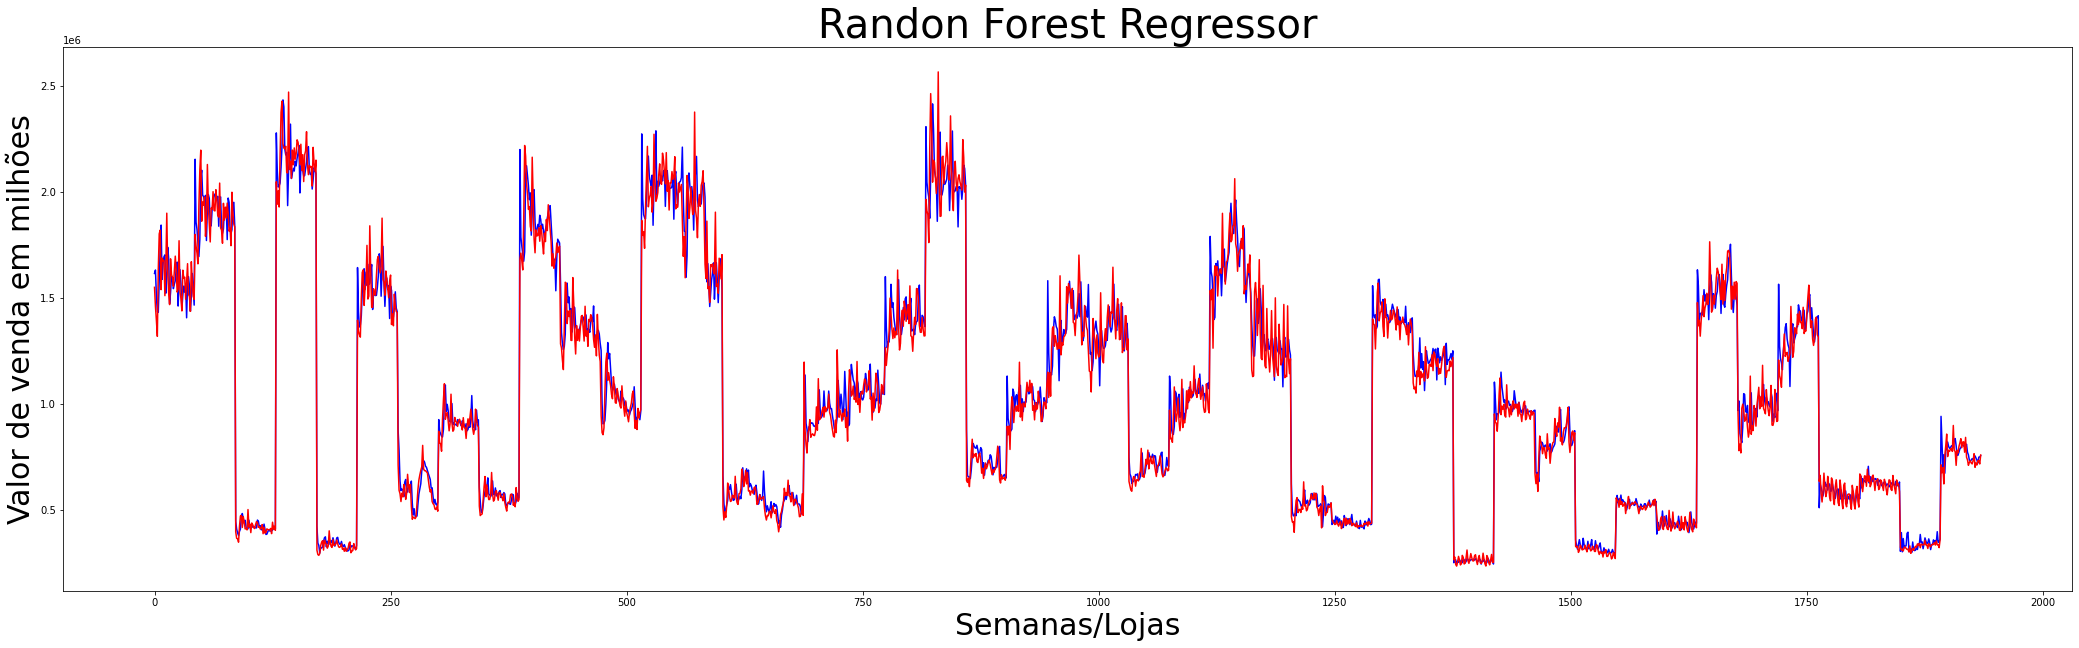

In [9]:
plt.figure(figsize = (36, 10)) 
plt.plot(range(len(predictions)), predictions, 'b')
plt.plot(range(len(predictions)), y_test, 'r')
plt.title("Randon Forest Regressor", fontsize=40)
plt.xlabel("Semanas/Lojas", fontsize=30)
plt.ylabel("Valor de venda em milhões", fontsize=30)

plt.show()

In [8]:
for i, feature in enumerate(rf.feature_names_in_):
  print("Feature {}: {}".format(feature, rf.feature_importances_[i]))


Feature Holiday_Flag: 0.00022995965937226245
Feature Temperature: 0.0023941759509890697
Feature Fuel_Price: 0.0009919006883661419
Feature CPI: 0.0014997058892543536
Feature Unemployment: 0.0008029571946476197
Feature Day: 0.008080487640503087
Feature Month_1: 0.0
Feature Month_2: 4.3779313056006305e-05
Feature Month_3: 0.0
Feature Month_4: 0.0
Feature Month_5: 0.0
Feature Month_6: 0.0
Feature Month_7: 0.0
Feature Month_8: 0.0
Feature Month_9: 4.1743965768445135e-06
Feature Month_10: 0.0
Feature Month_11: 0.0011848431925338431
Feature Month_12: 0.0035814521771318597
Feature Store_1: 0.0
Feature Store_2: 6.235463894692435e-06
Feature Store_3: 0.0
Feature Store_4: 0.0
Feature Store_5: 0.0
Feature Store_6: 0.0
Feature Store_7: 0.0
Feature Store_8: 2.2290582158446515e-05
Feature Store_9: 0.0
Feature Store_10: 4.902935637819472e-06
Feature Store_11: 0.0
Feature Store_12: 0.0
Feature Store_13: 0.0
Feature Store_14: 3.406710447431069e-05
Feature Store_15: 0.0
Feature Store_16: 0.0
Feature Stor

Resultados Loja 1:
-0.20169135307282726 98794.15084715768 124679.44951560666


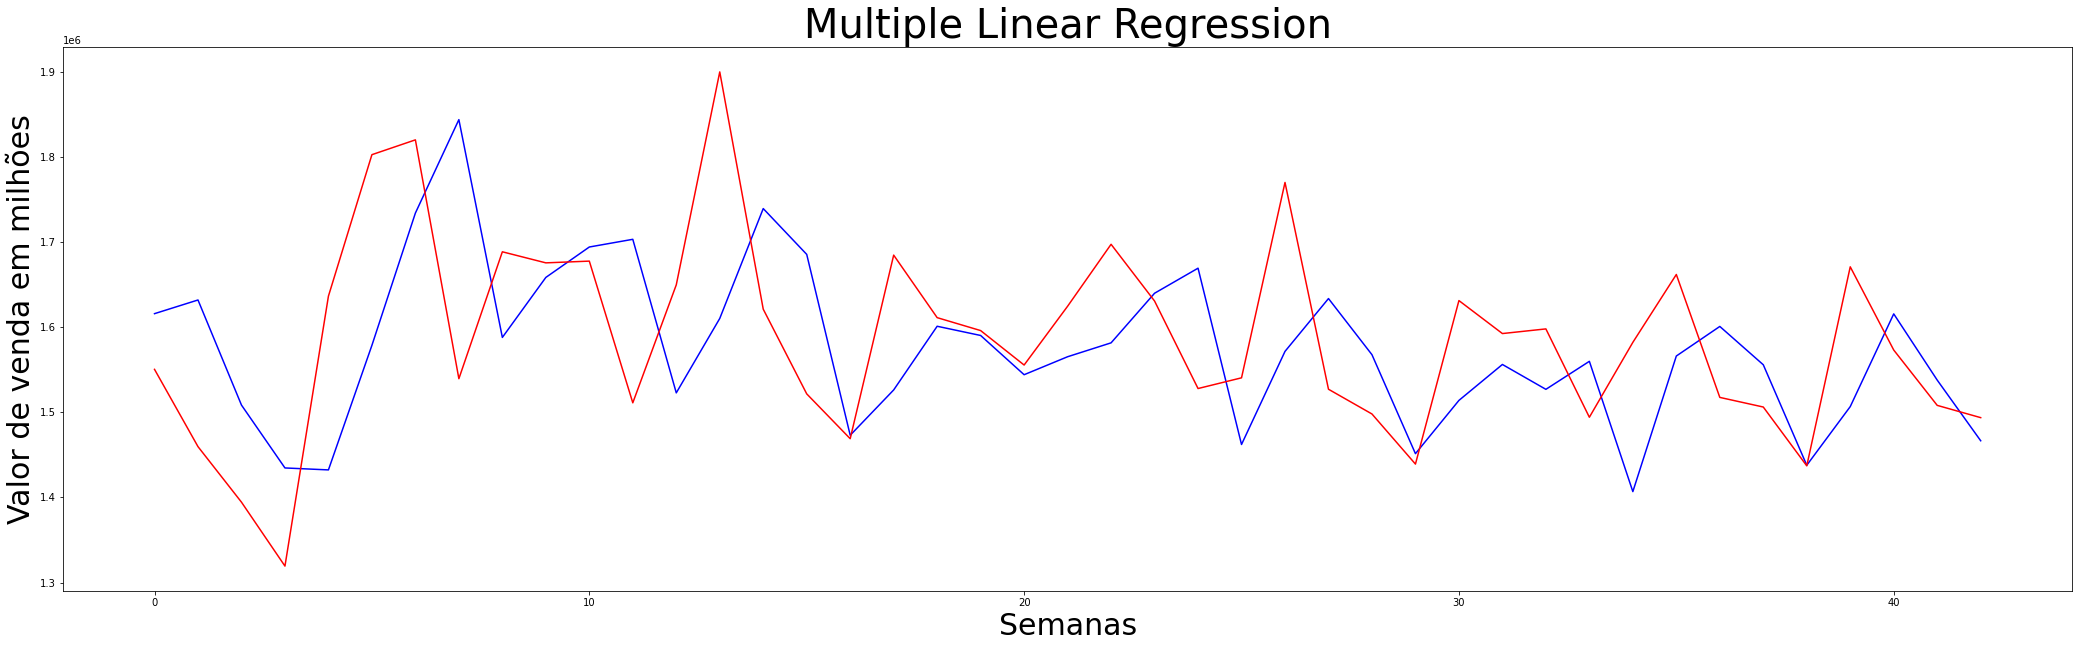

**************************************************
Resultados Loja 2:
-0.406327104504558 97511.65550588582 127291.14123547667


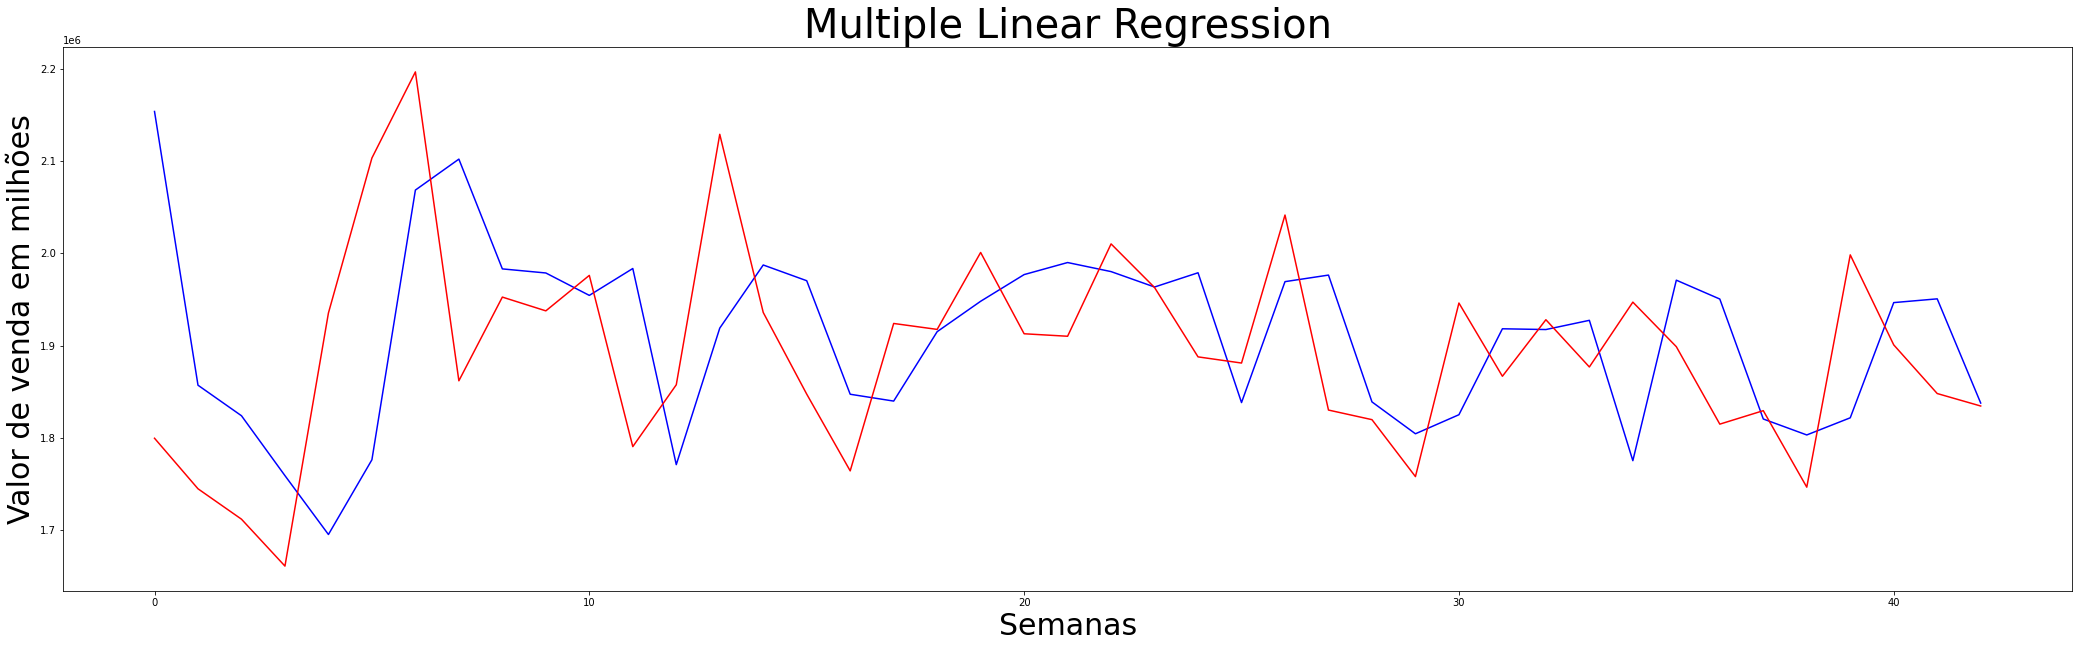

**************************************************
Resultados Loja 3:
0.03479137651526032 20865.388118020943 28046.555617572827


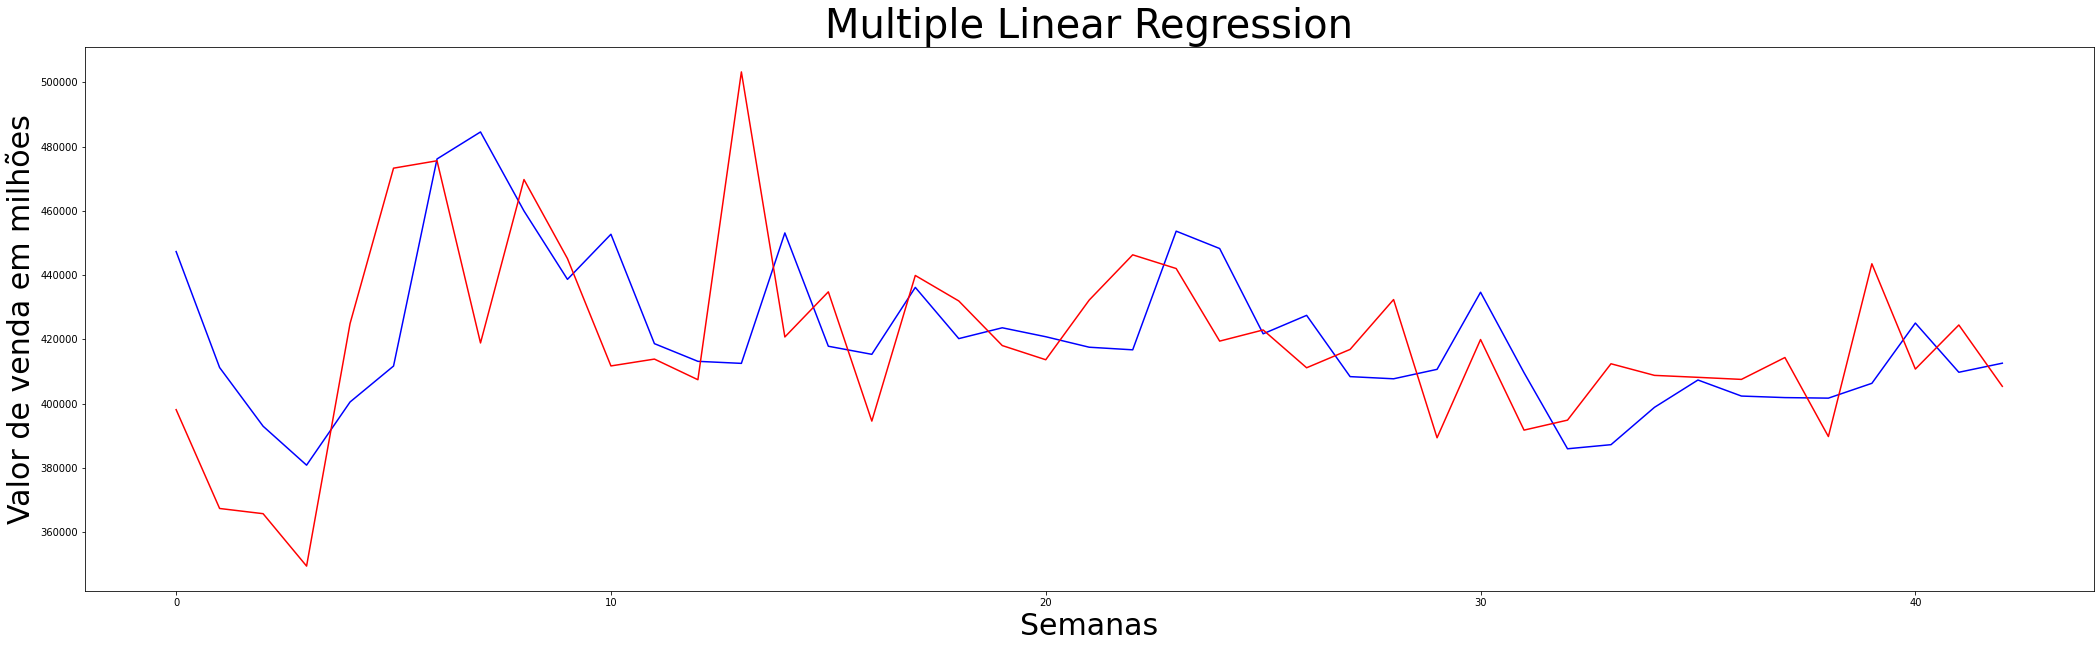

**************************************************
Resultados Loja 4:
-0.39885372626733484 96348.32038510144 124846.98195746428


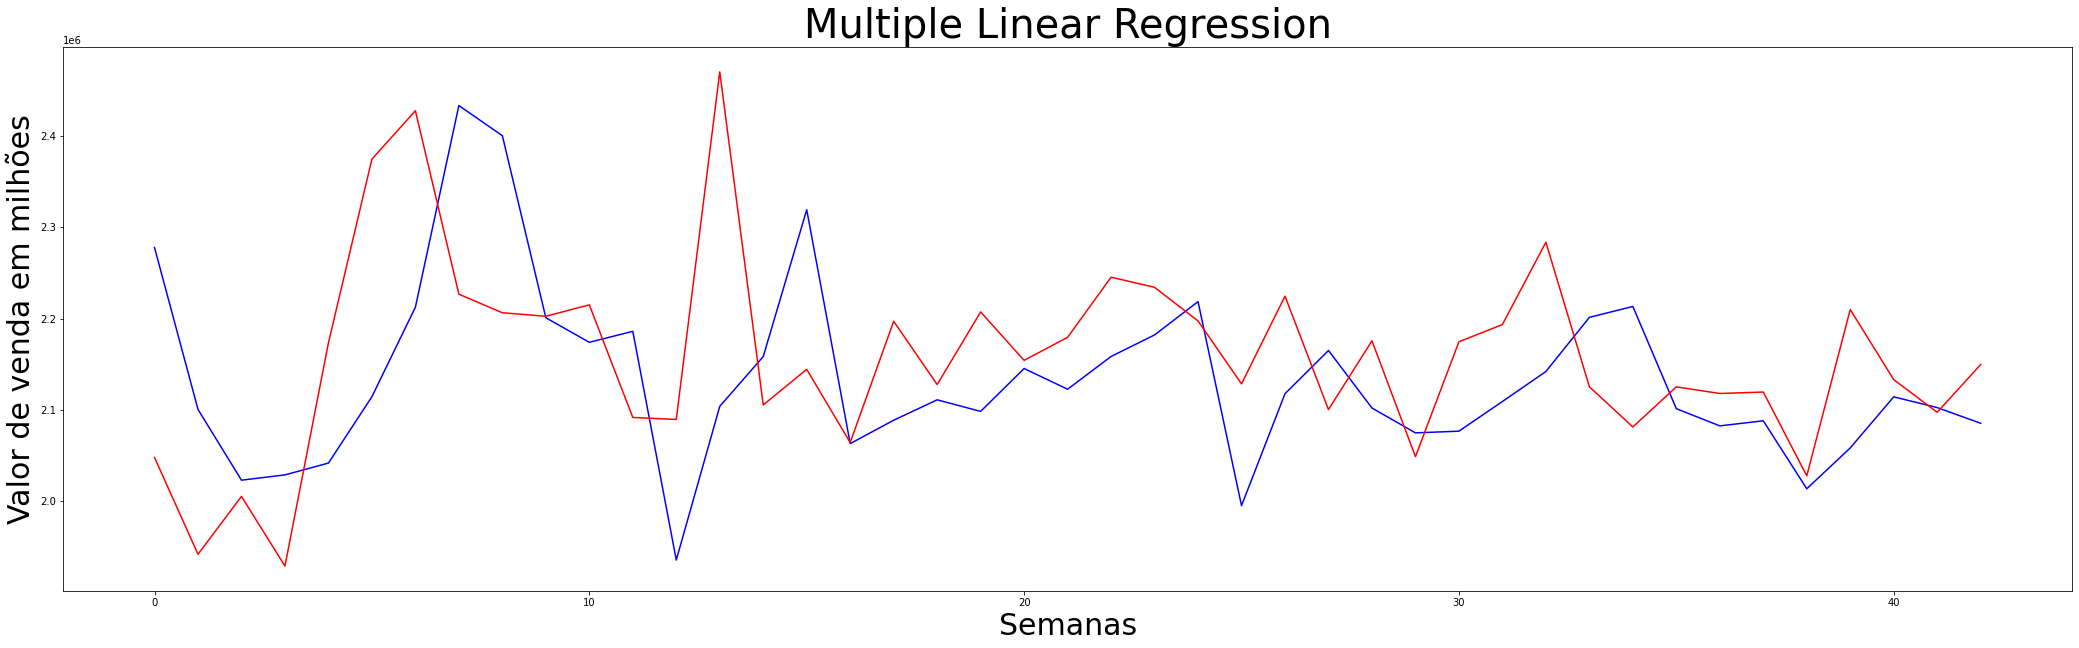

**************************************************
Resultados Loja 5:
-0.6500540852171461 20628.31179491621 27982.54833675752


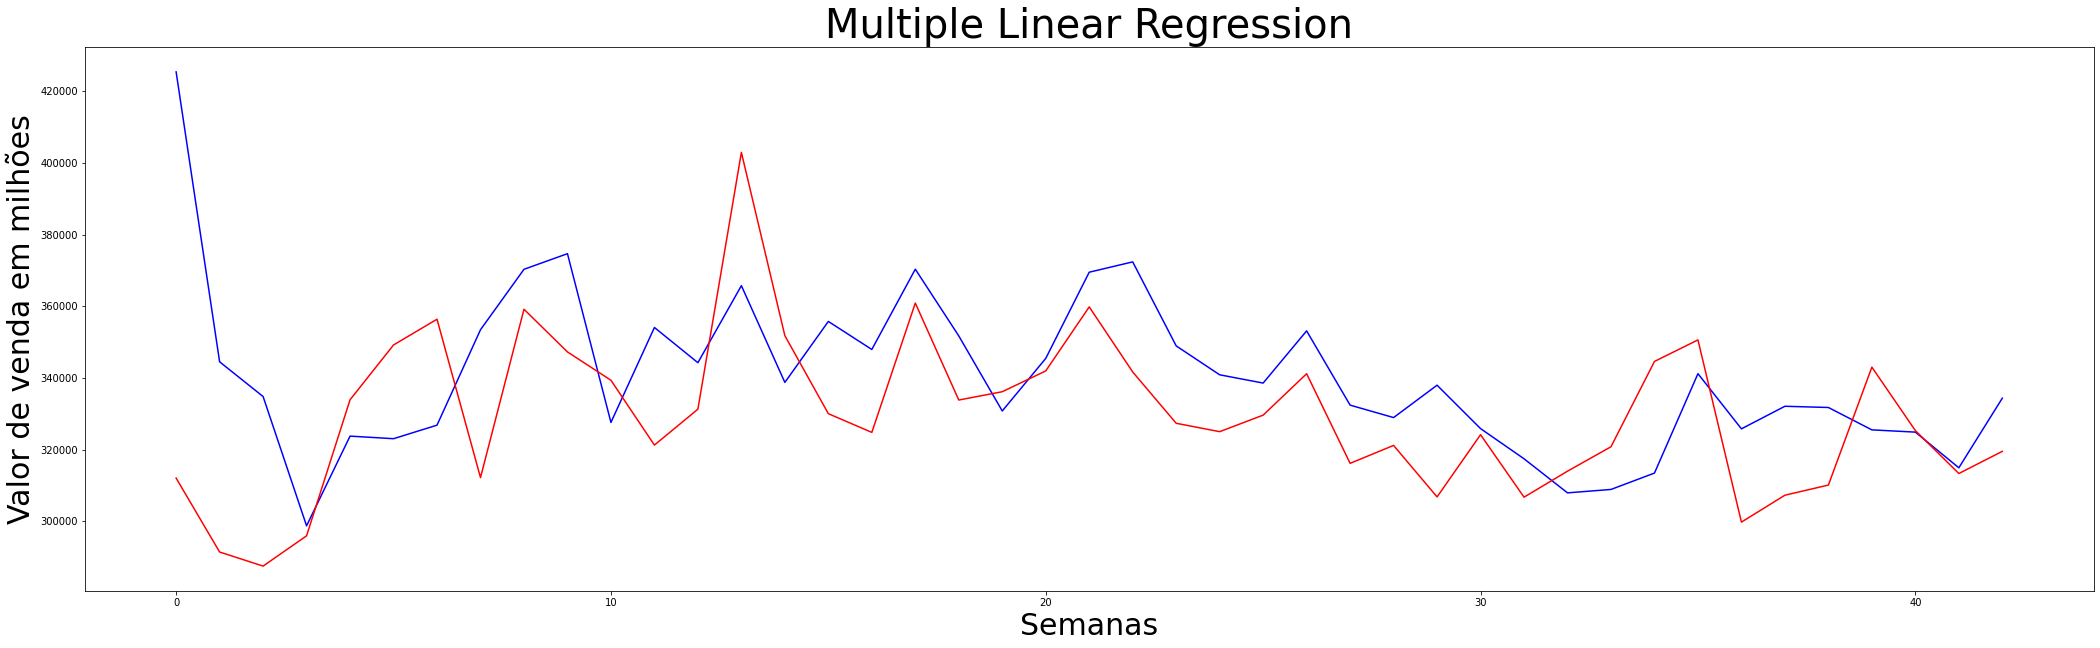

**************************************************
Resultados Loja 6:
0.17301295031718888 83237.44346327963 111527.03234710205


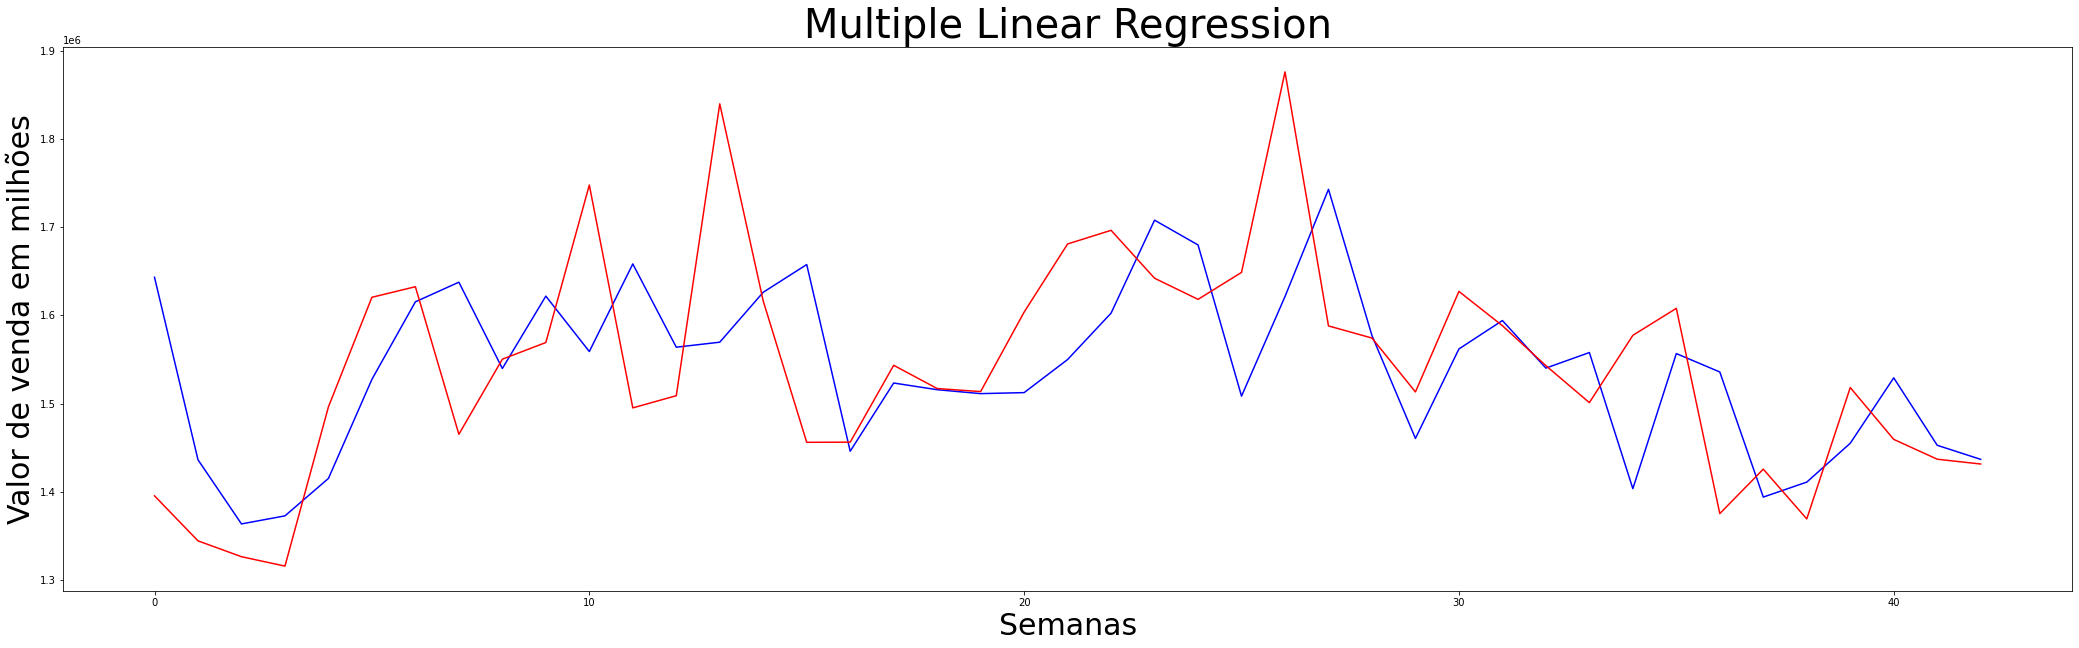

**************************************************
Resultados Loja 7:
0.41194189500037814 47783.12206443758 62160.18647612617


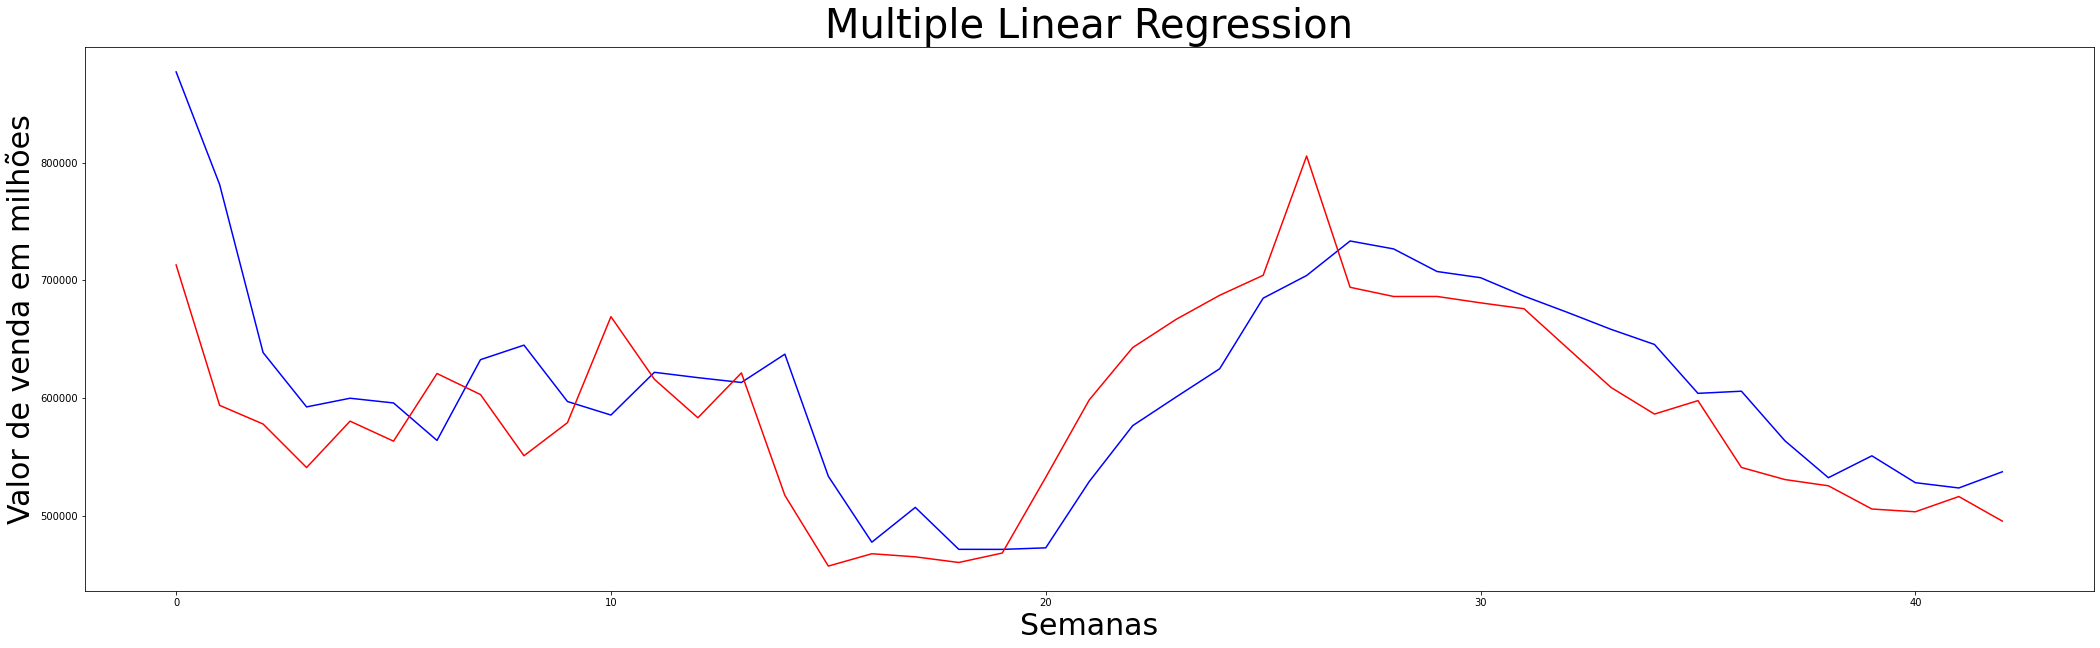

**************************************************
Resultados Loja 8:
-0.09594388654772534 45269.08661211594 58829.81571927813


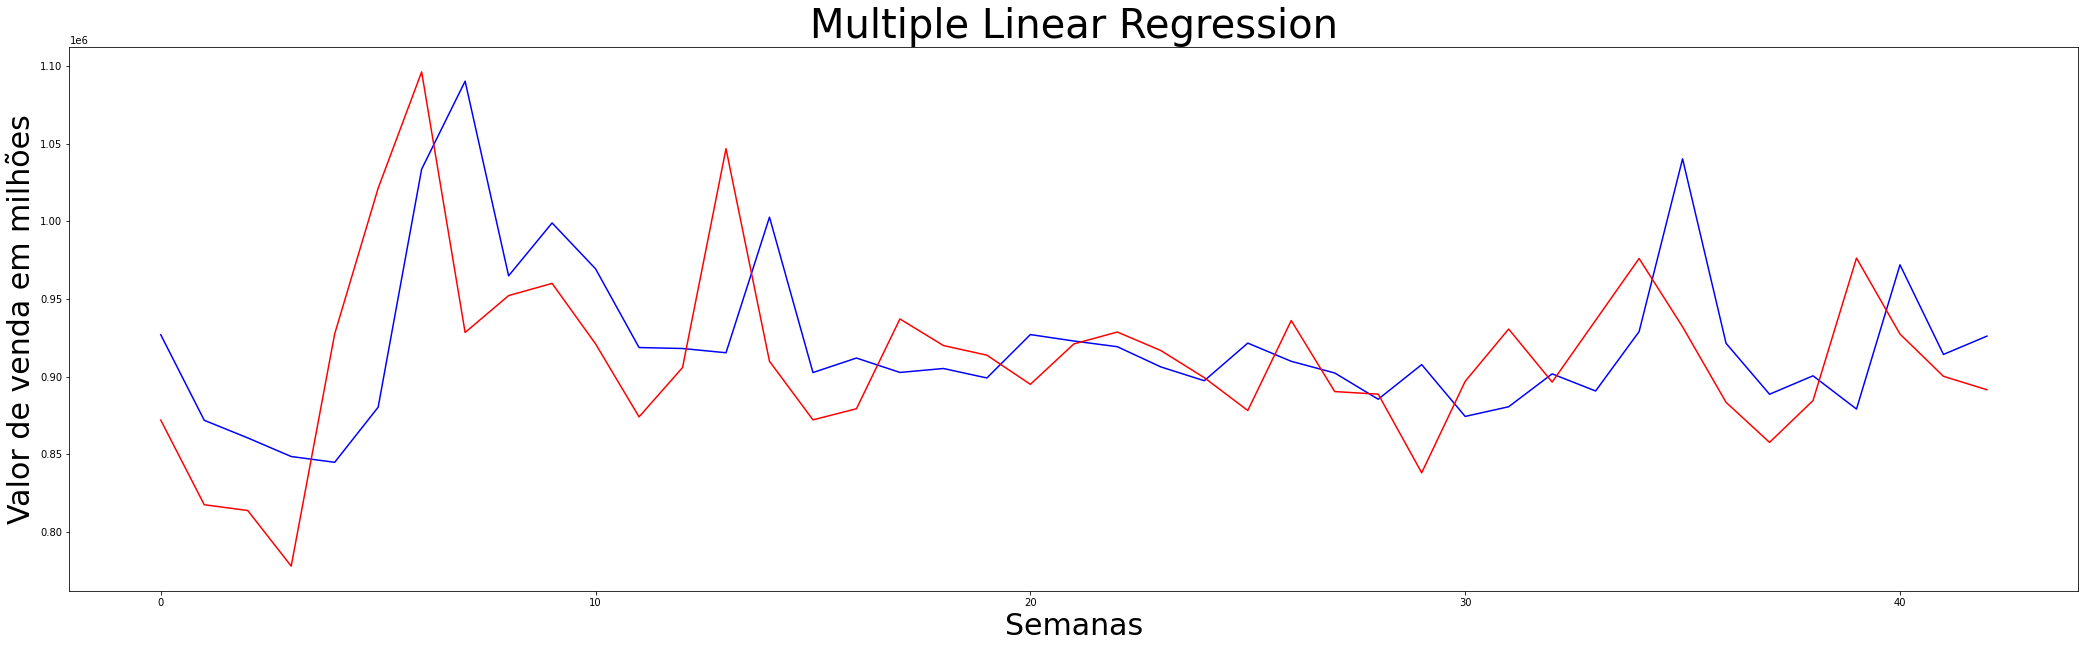

**************************************************
Resultados Loja 9:
0.14992950391894966 28125.51006697074 37583.280788012926


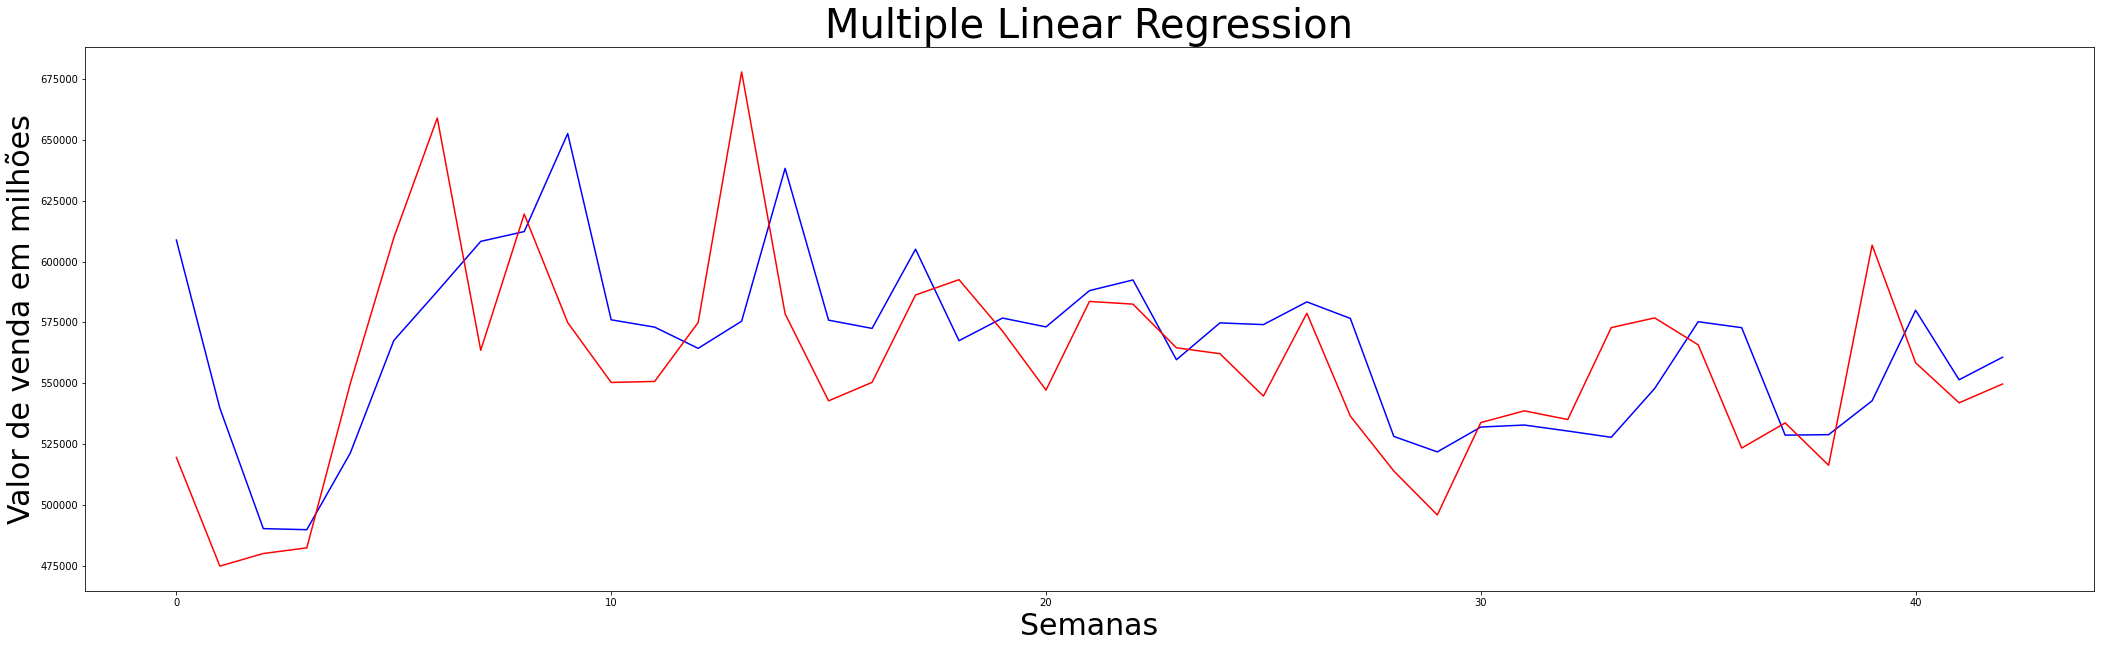

**************************************************
Resultados Loja 10:
-0.11509407178525577 96009.70645035506 145023.72639020407


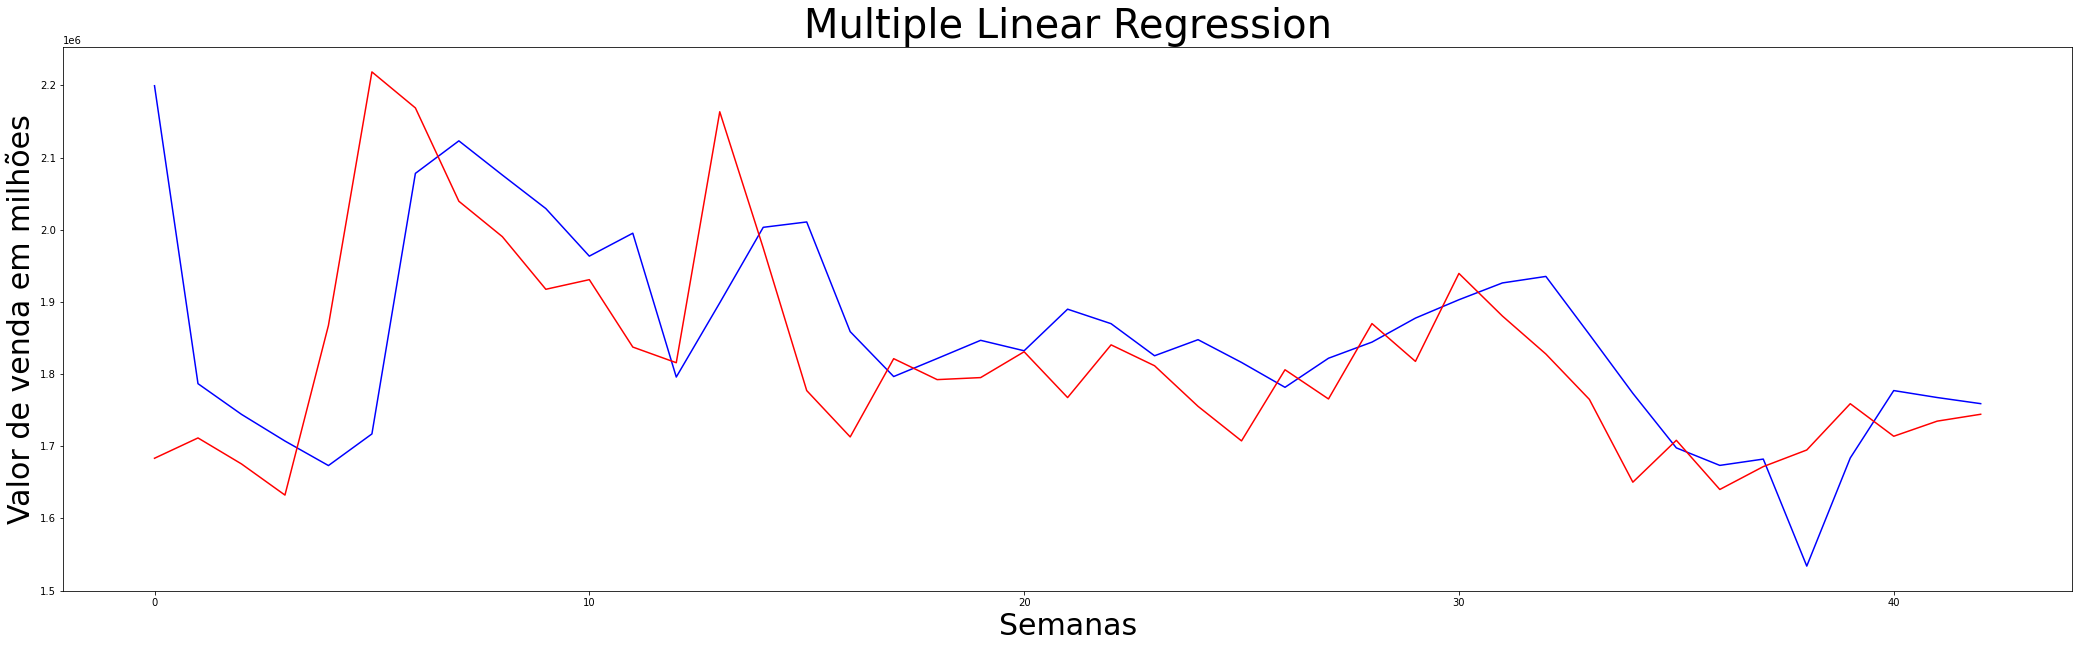

**************************************************
Resultados Loja 11:
-0.10666100597297268 77482.82656120426 101339.26590998276


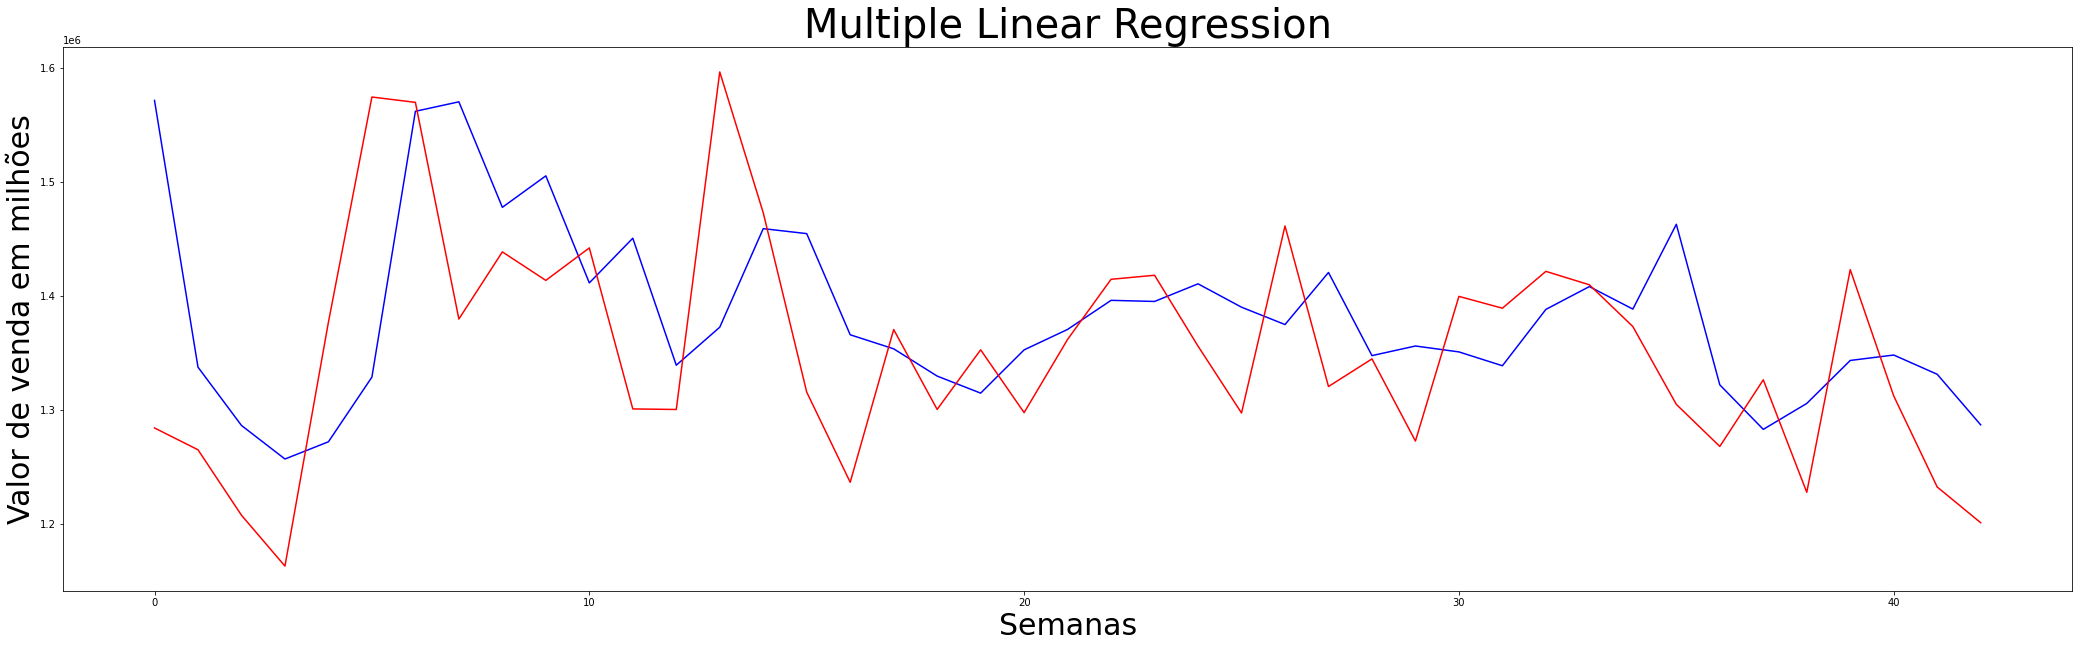

**************************************************
Resultados Loja 12:
-0.011531953869225342 61309.13629865053 86162.90287559503


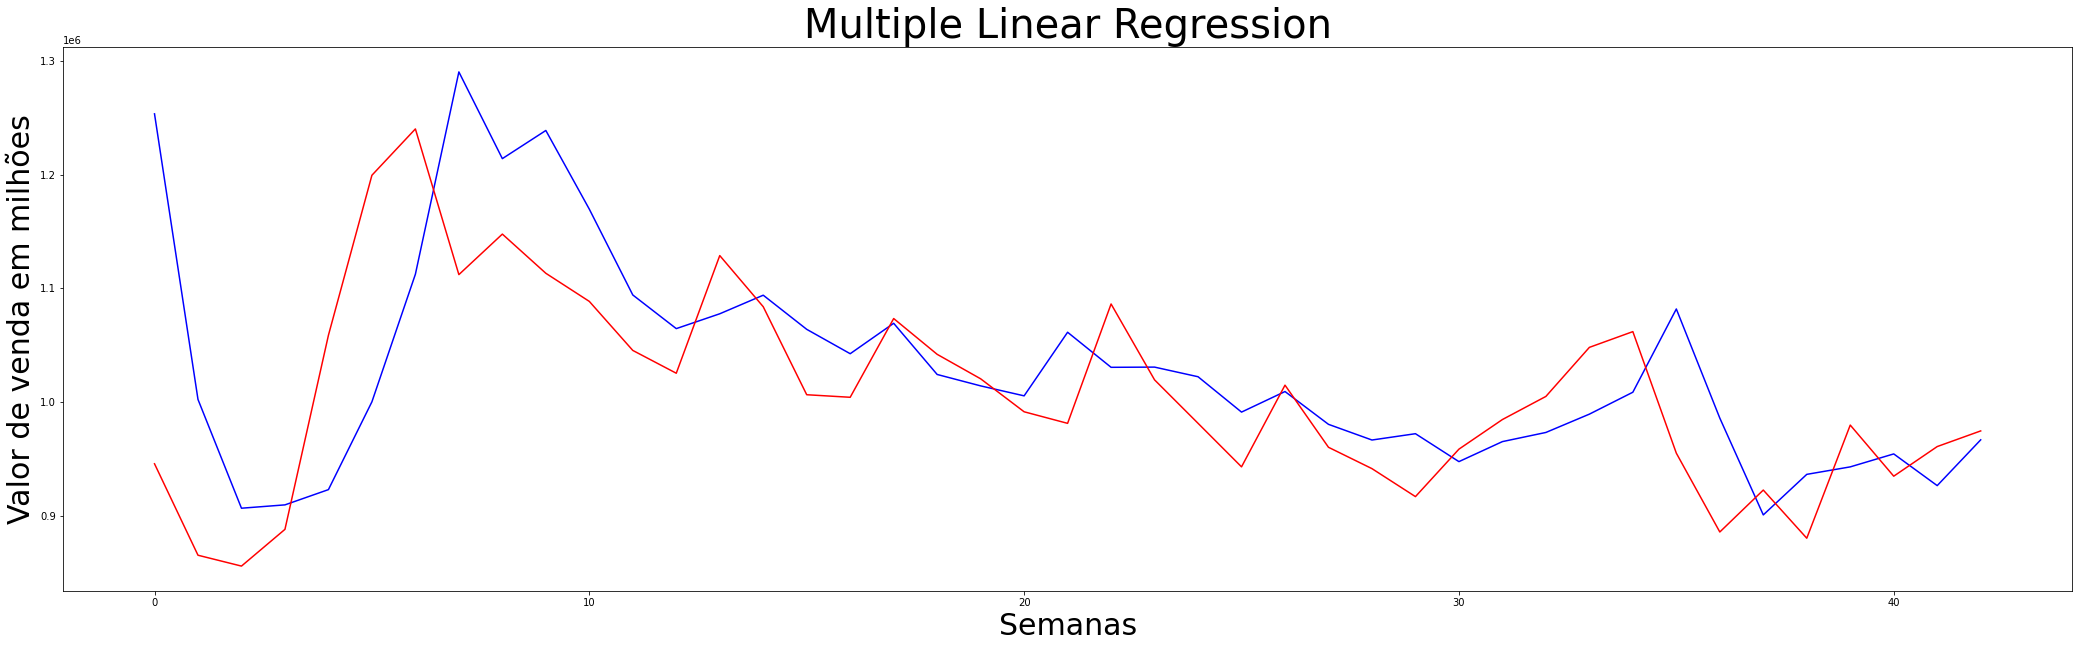

**************************************************
Resultados Loja 13:
-0.3764083944566745 95673.45760754585 128435.68319747958


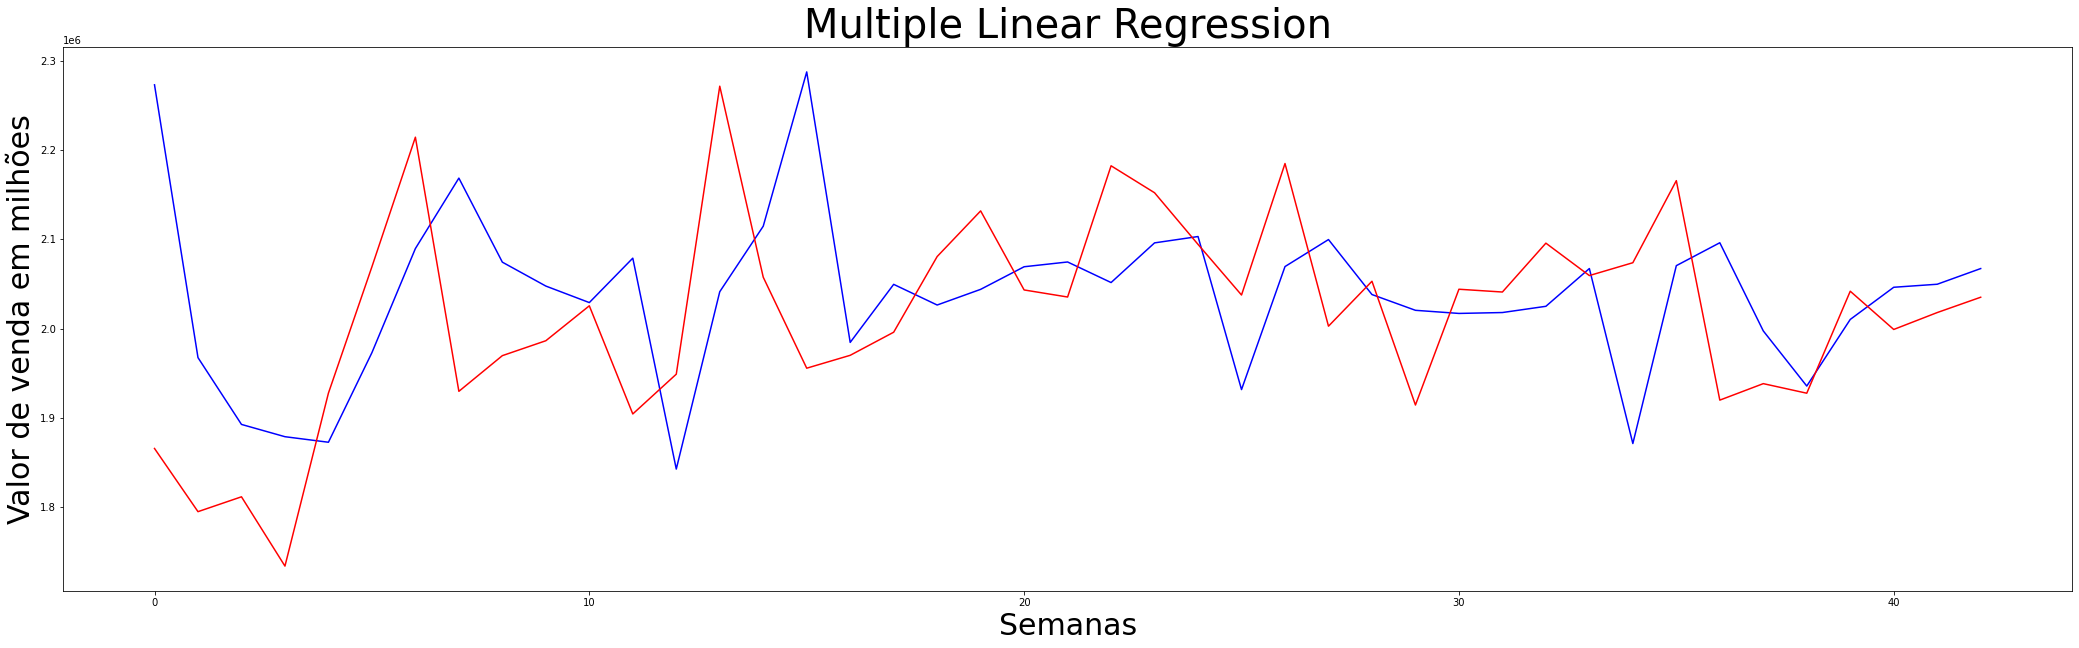

**************************************************
Resultados Loja 14:
0.23987166484253708 133417.89174777982 171269.93203517192


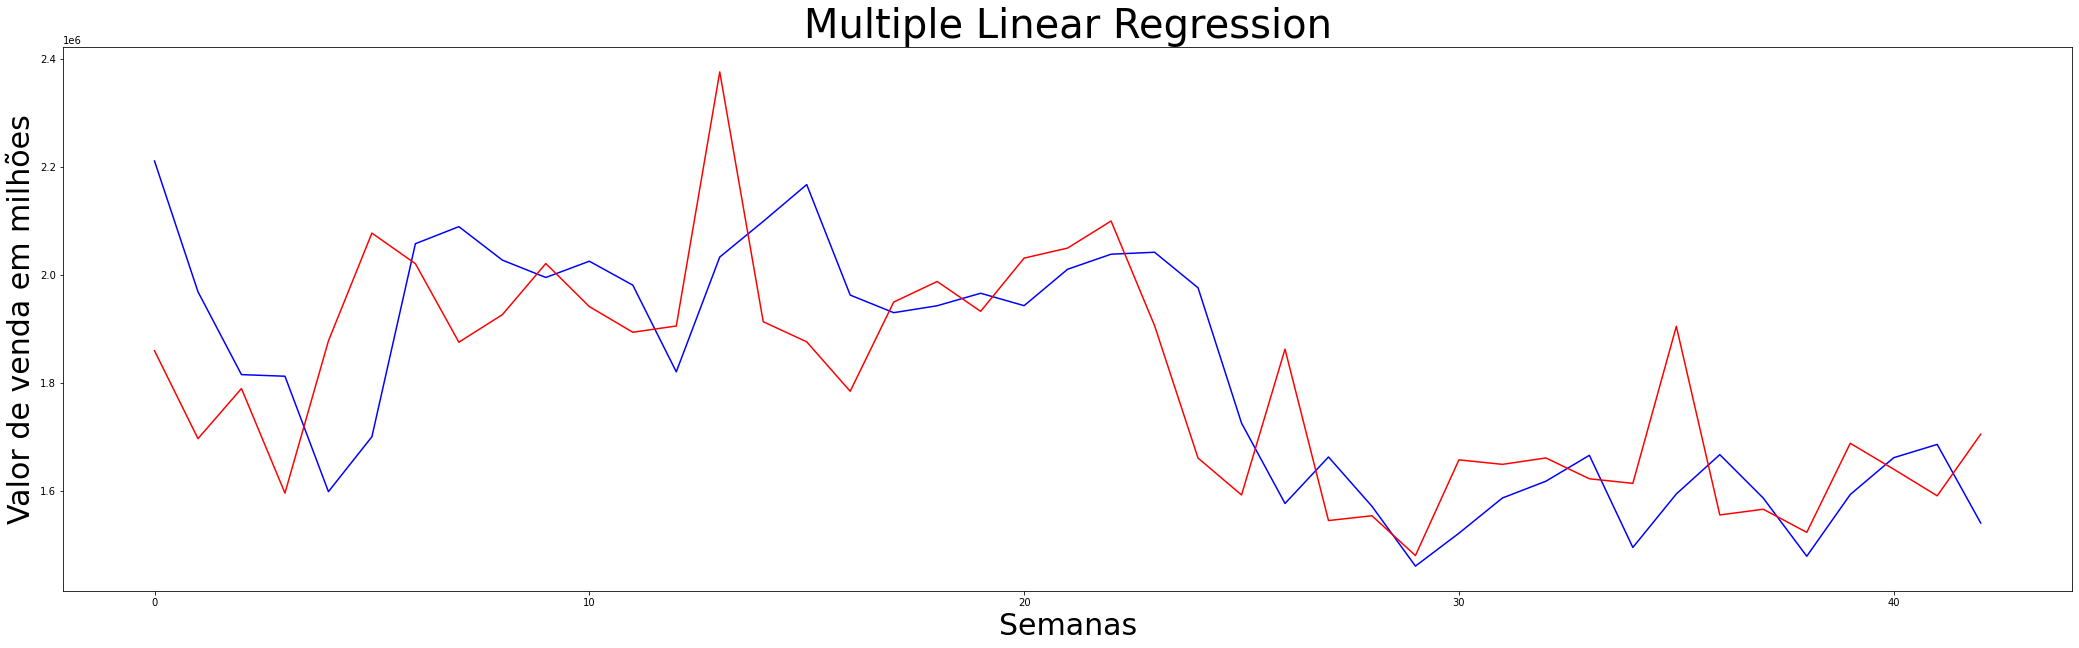

**************************************************
Resultados Loja 15:
0.1997655356823984 34946.93376620481 47053.492087243765


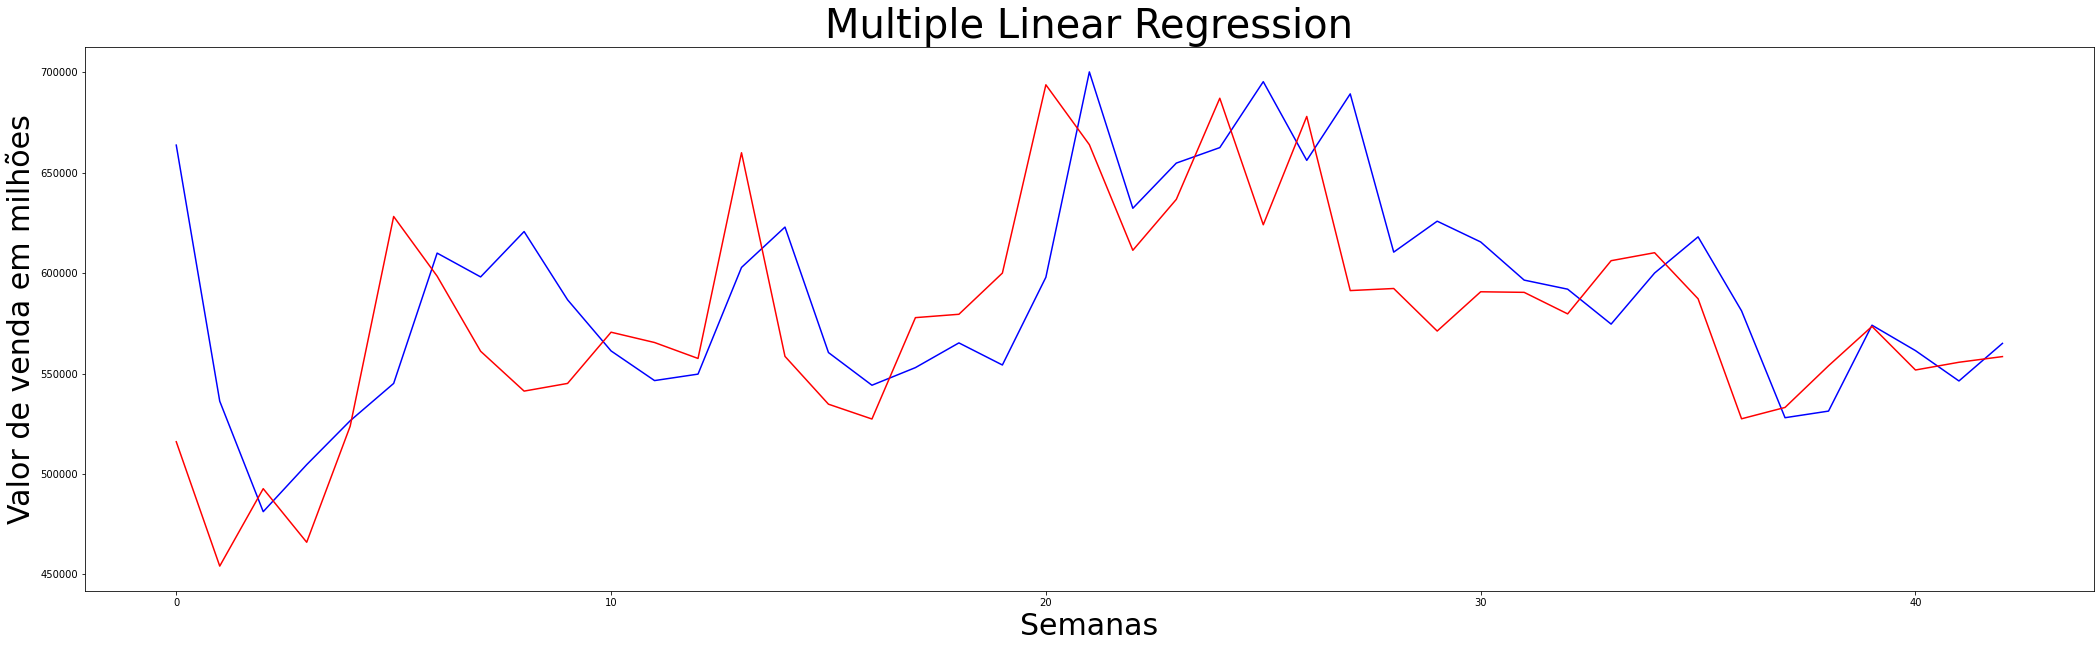

**************************************************
Resultados Loja 16:
0.24327166221781293 35873.72602385616 44013.6641579033


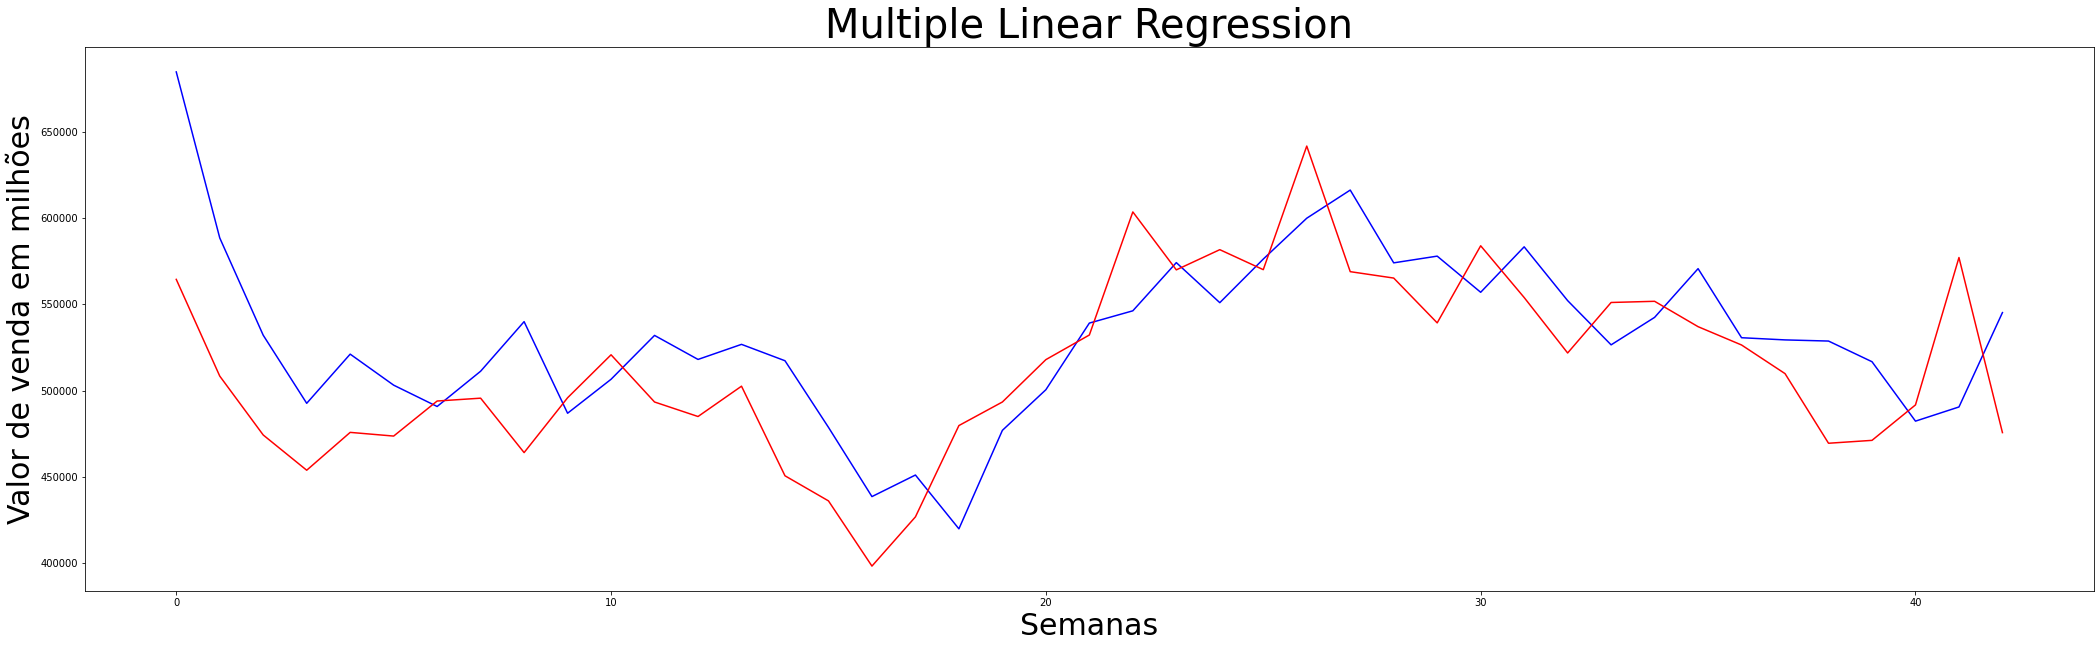

**************************************************
Resultados Loja 17:
-0.2222864820828756 71215.67094387299 103290.89484987808


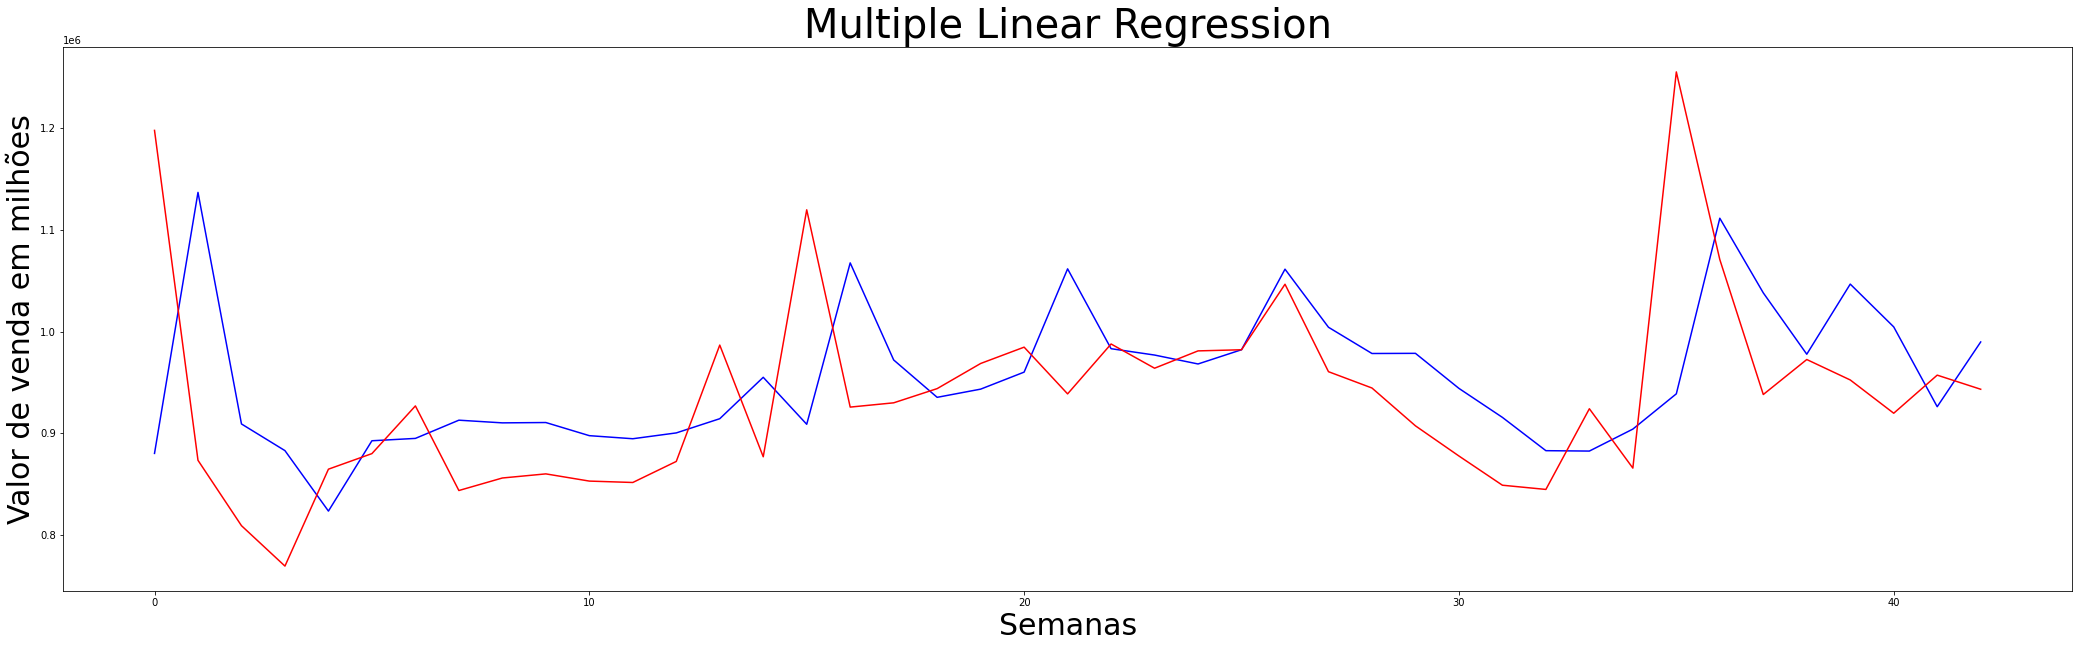

**************************************************
Resultados Loja 18:
-0.5087369649189055 70404.68841358634 90883.14057570221


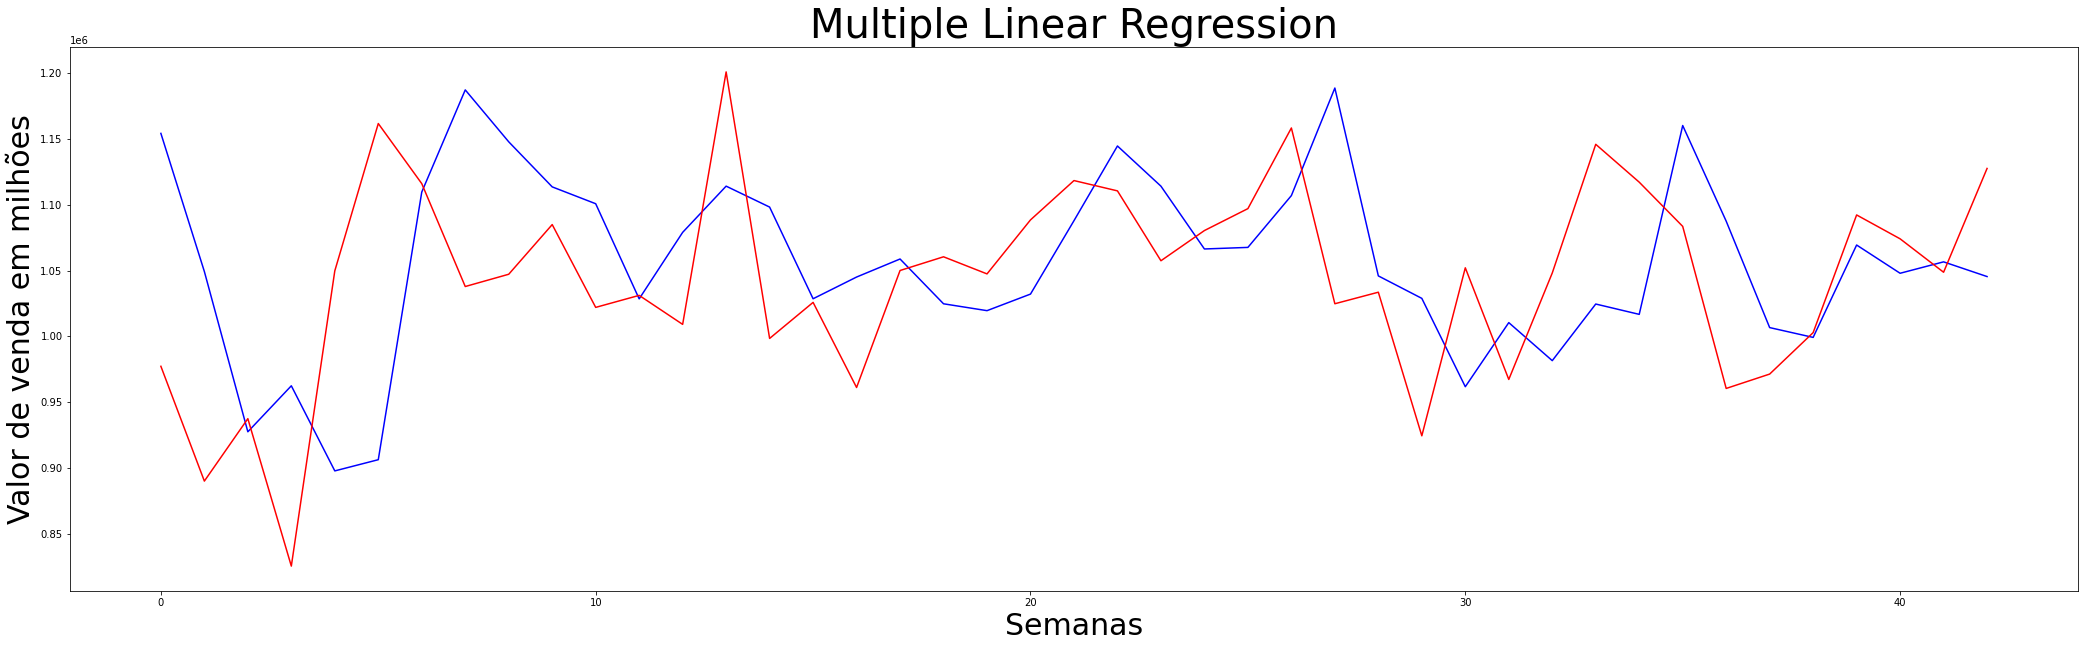

**************************************************
Resultados Loja 19:
-0.4659602782738219 87405.65745937478 112670.26392721292


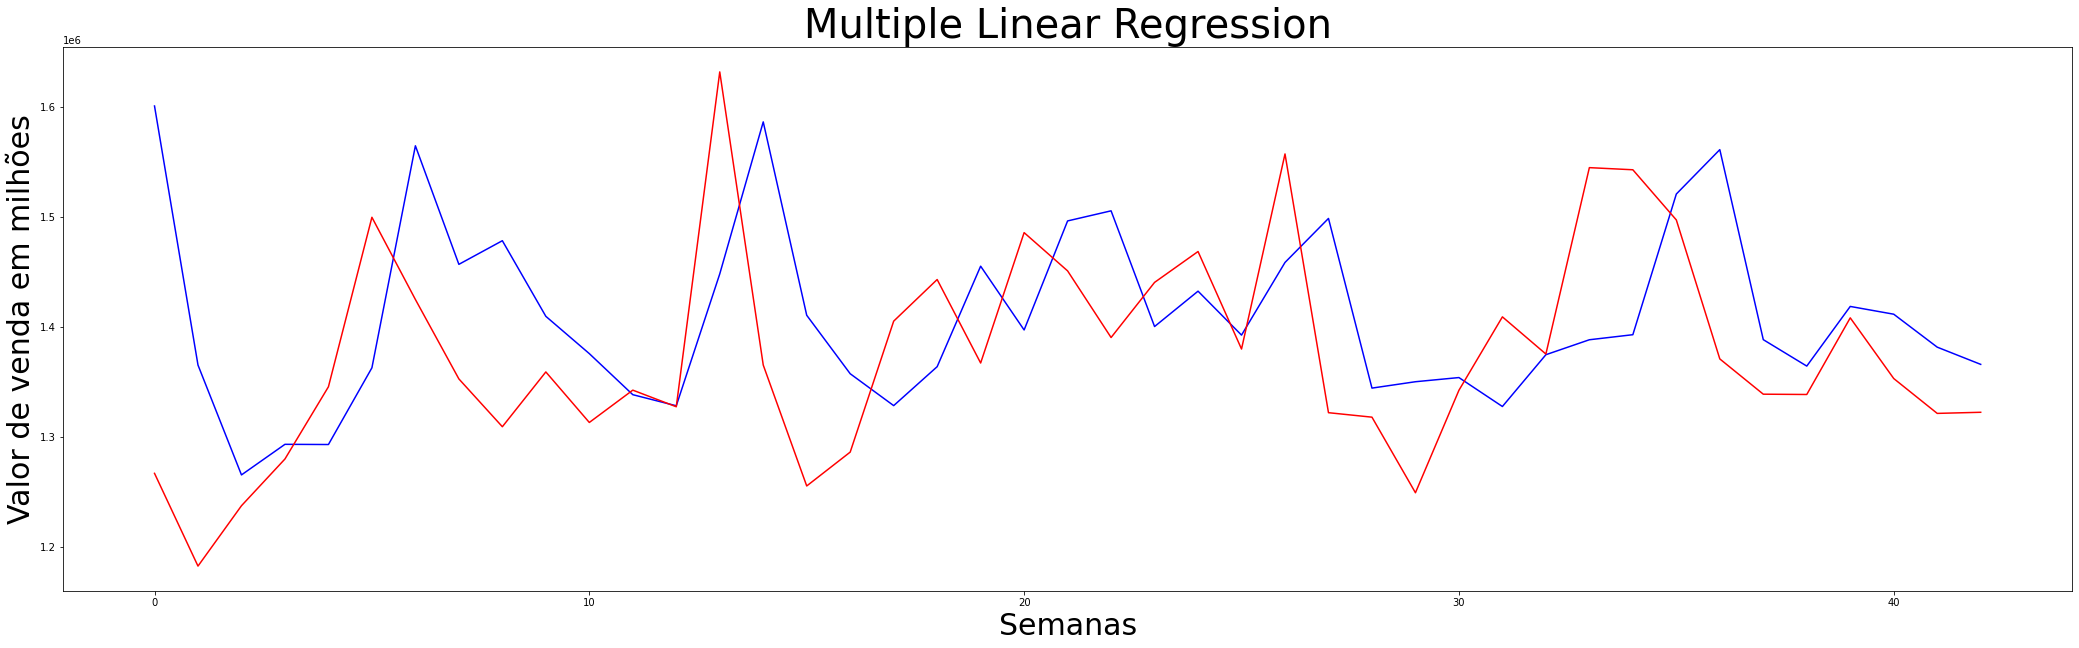

**************************************************
Resultados Loja 20:
-0.6533780055809262 145408.51935603606 191763.74552257473


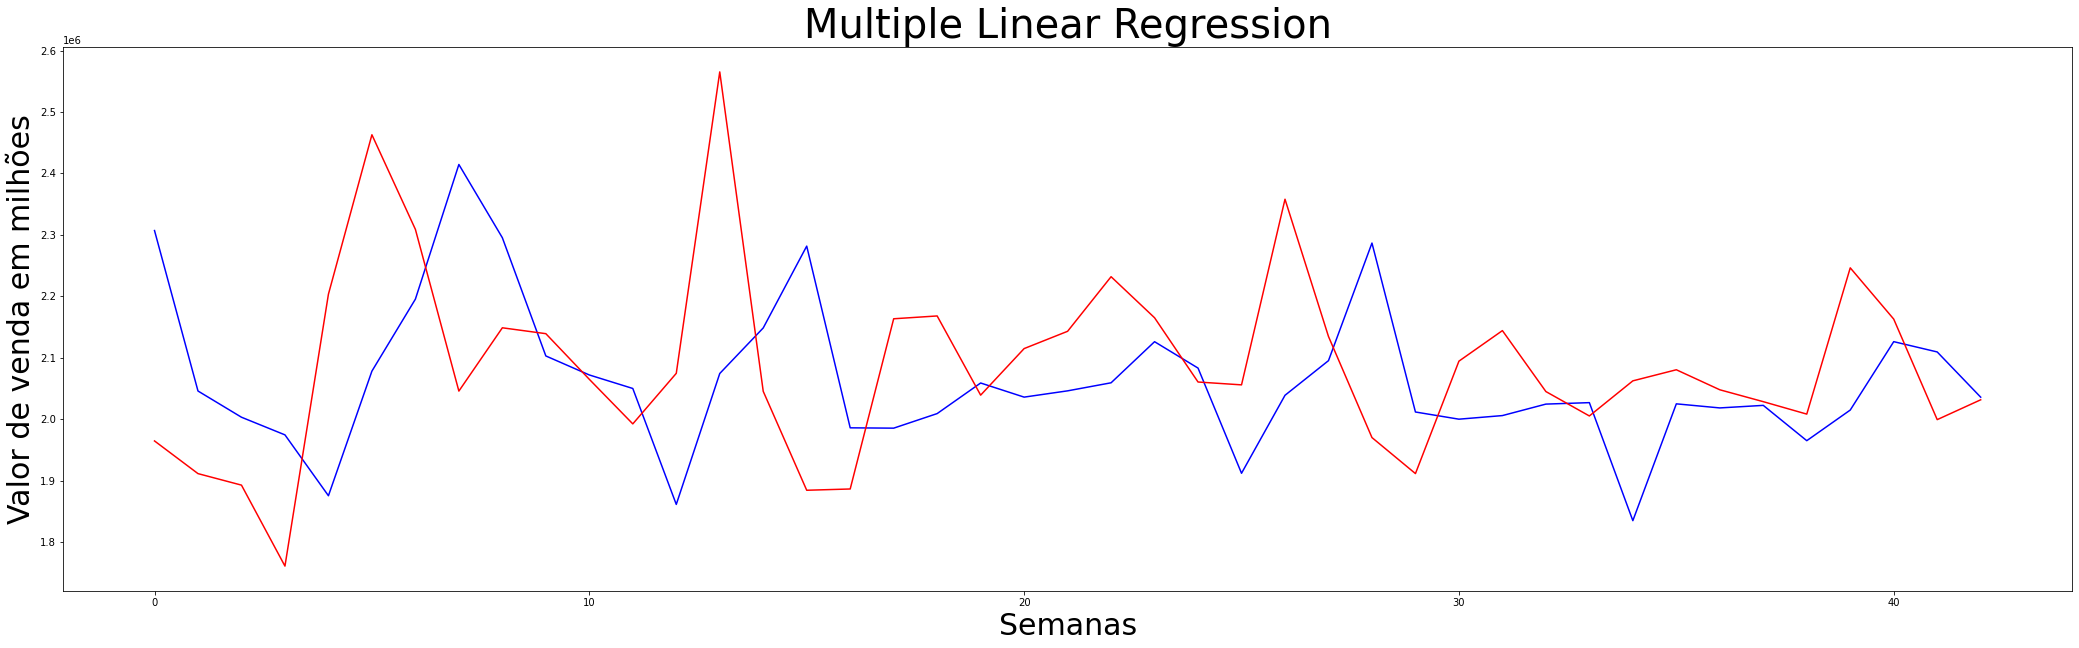

**************************************************
Resultados Loja 21:
-0.41667185458725275 41834.1264933491 60897.688074844526


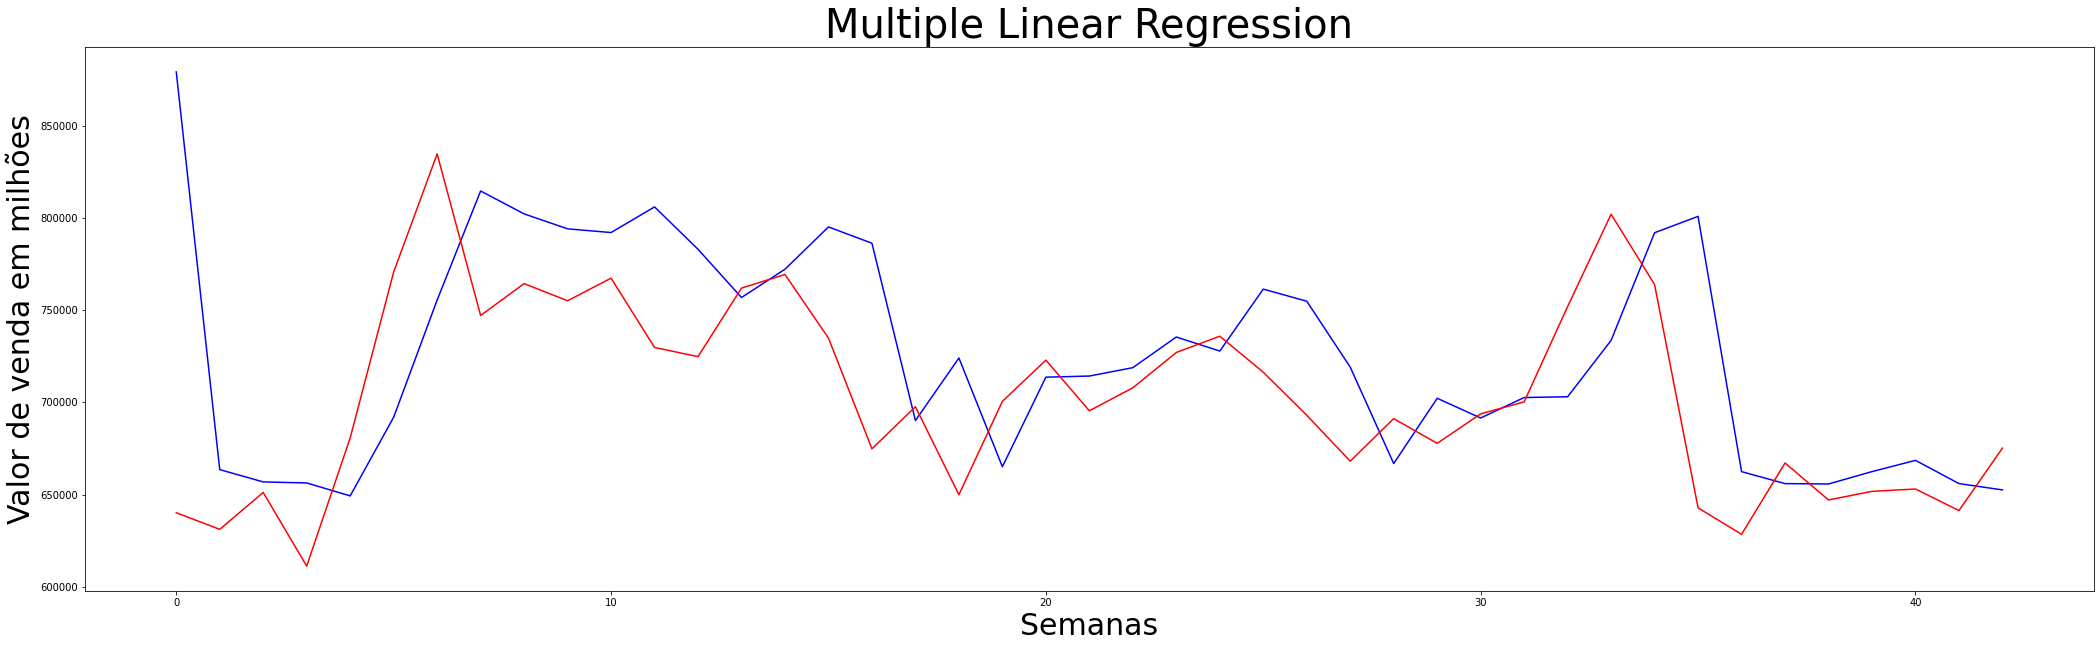

**************************************************
Resultados Loja 22:
-0.10553133674760828 57882.63153503949 76530.00488153758


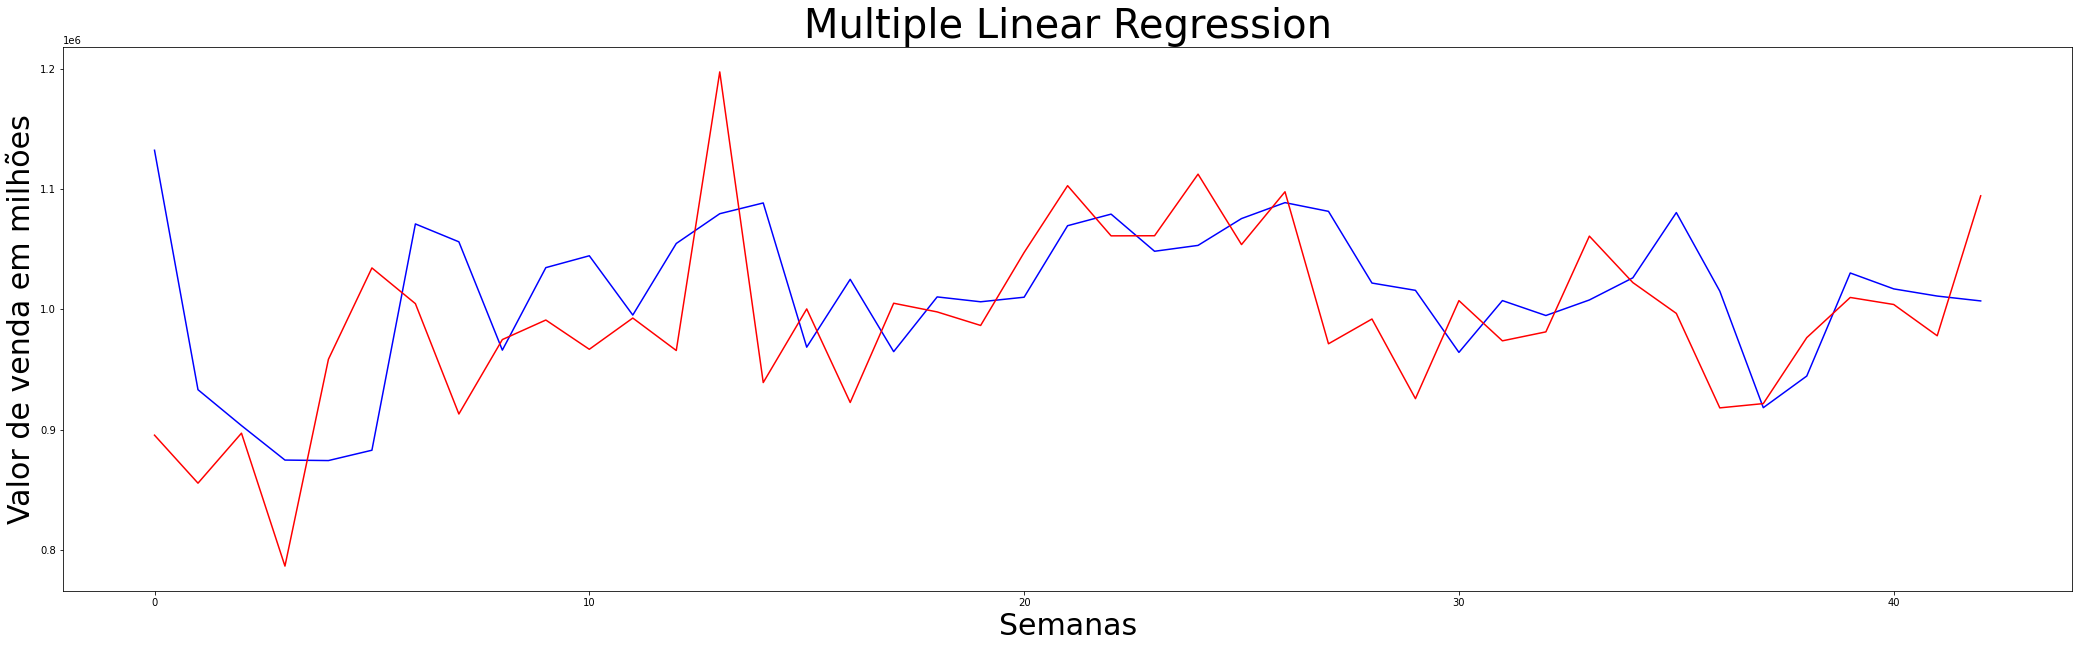

**************************************************
Resultados Loja 23:
0.25626968691469787 87198.80082462968 122108.20039386081


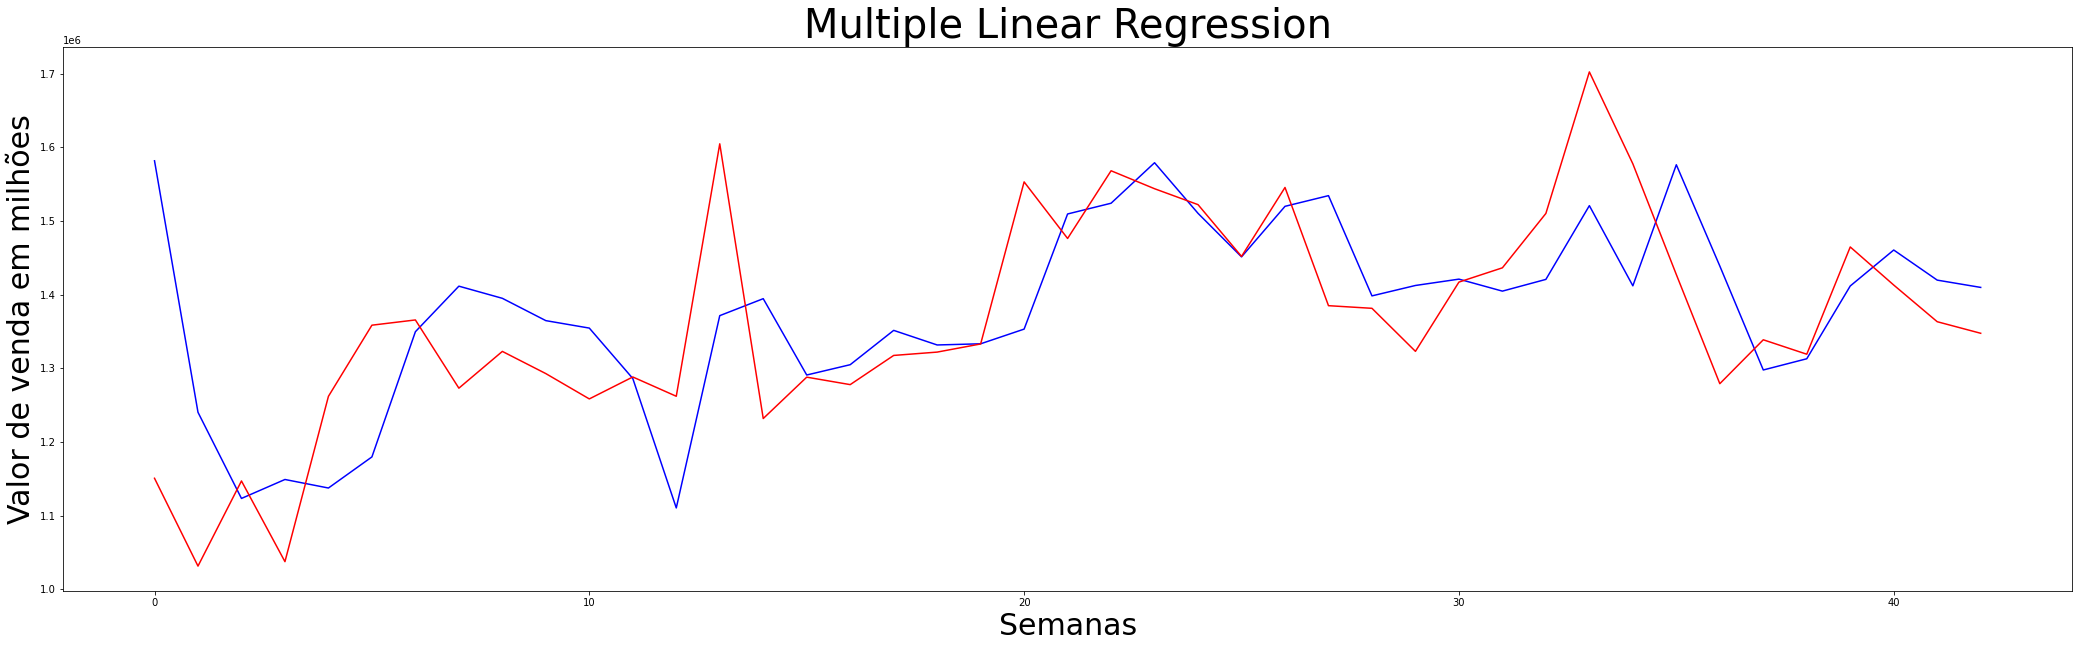

**************************************************
Resultados Loja 24:
-0.11719356227047828 94916.13442350614 118648.24771657851


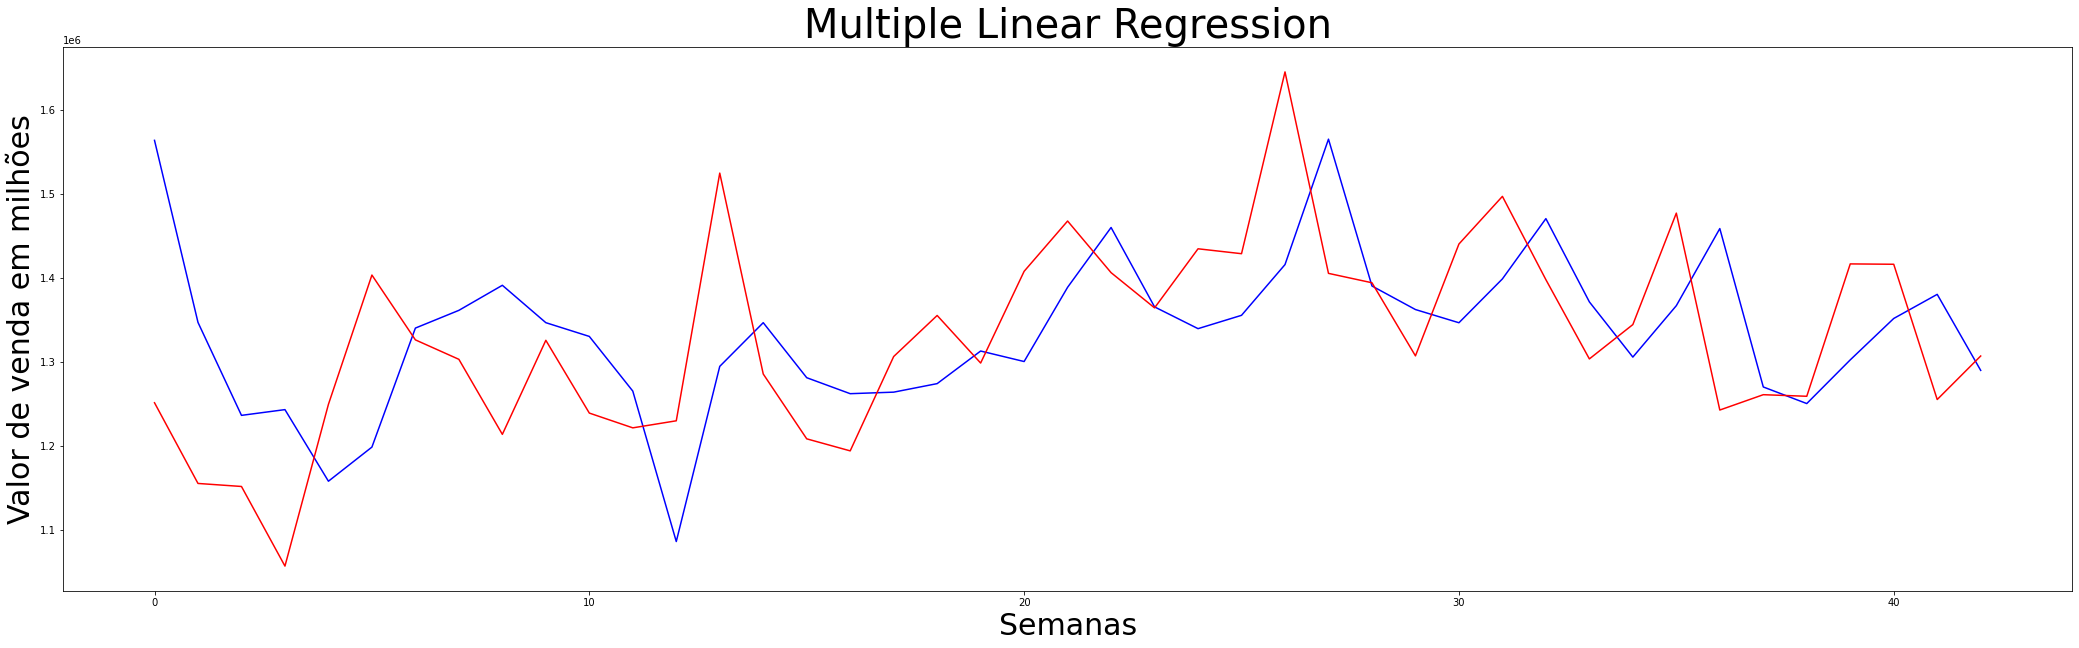

**************************************************
Resultados Loja 25:
0.0436102251632382 34518.69024981698 45384.693948149594


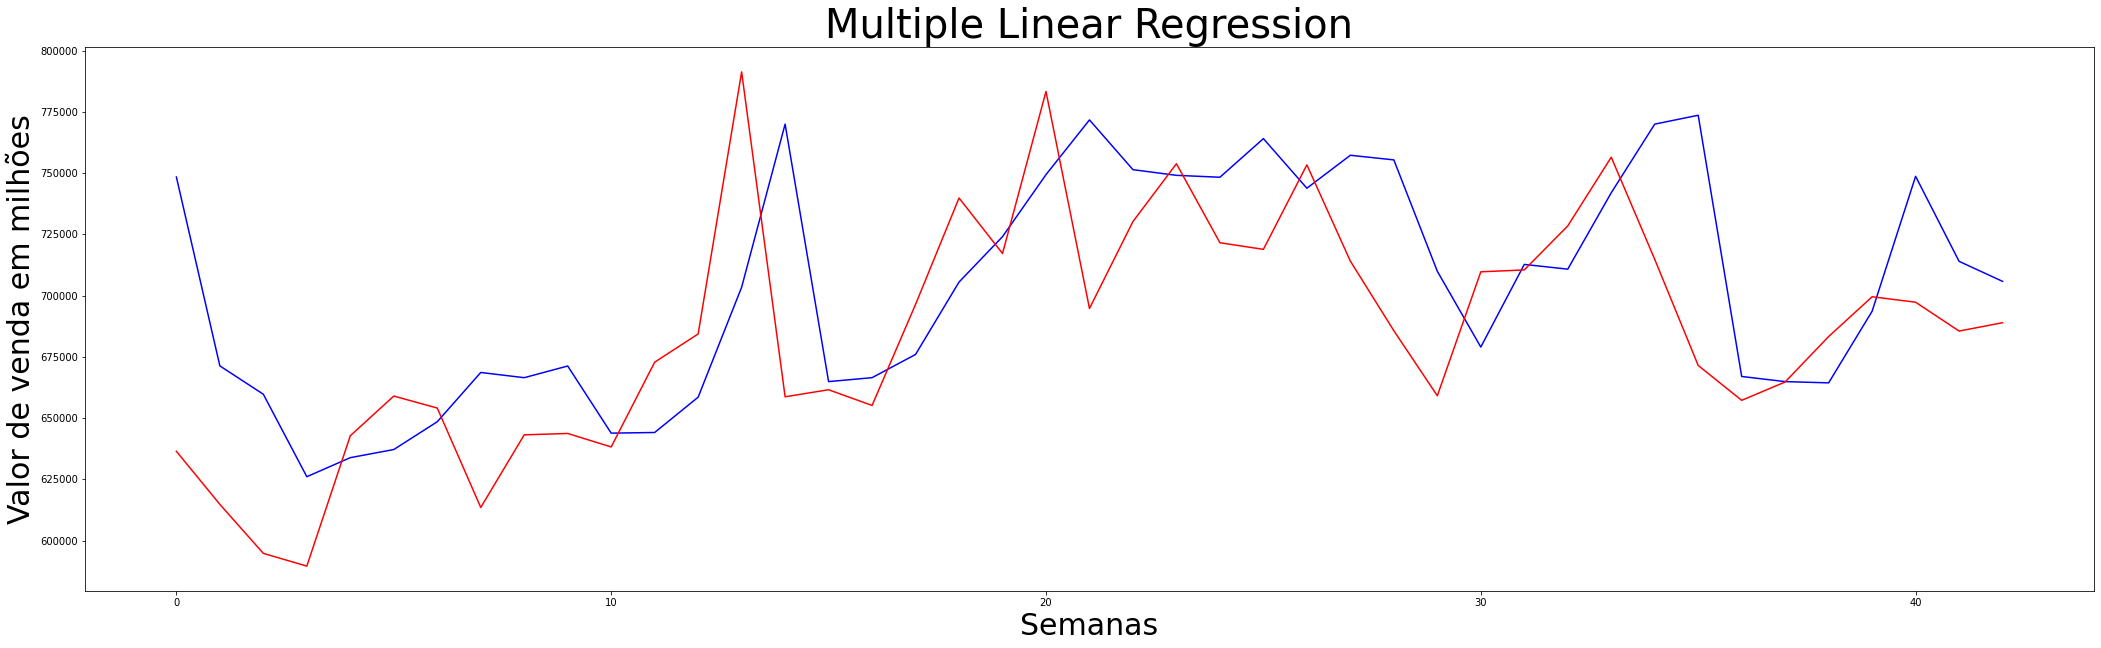

**************************************************
Resultados Loja 26:
-0.08695709445905453 67036.89287265312 86892.00945878823


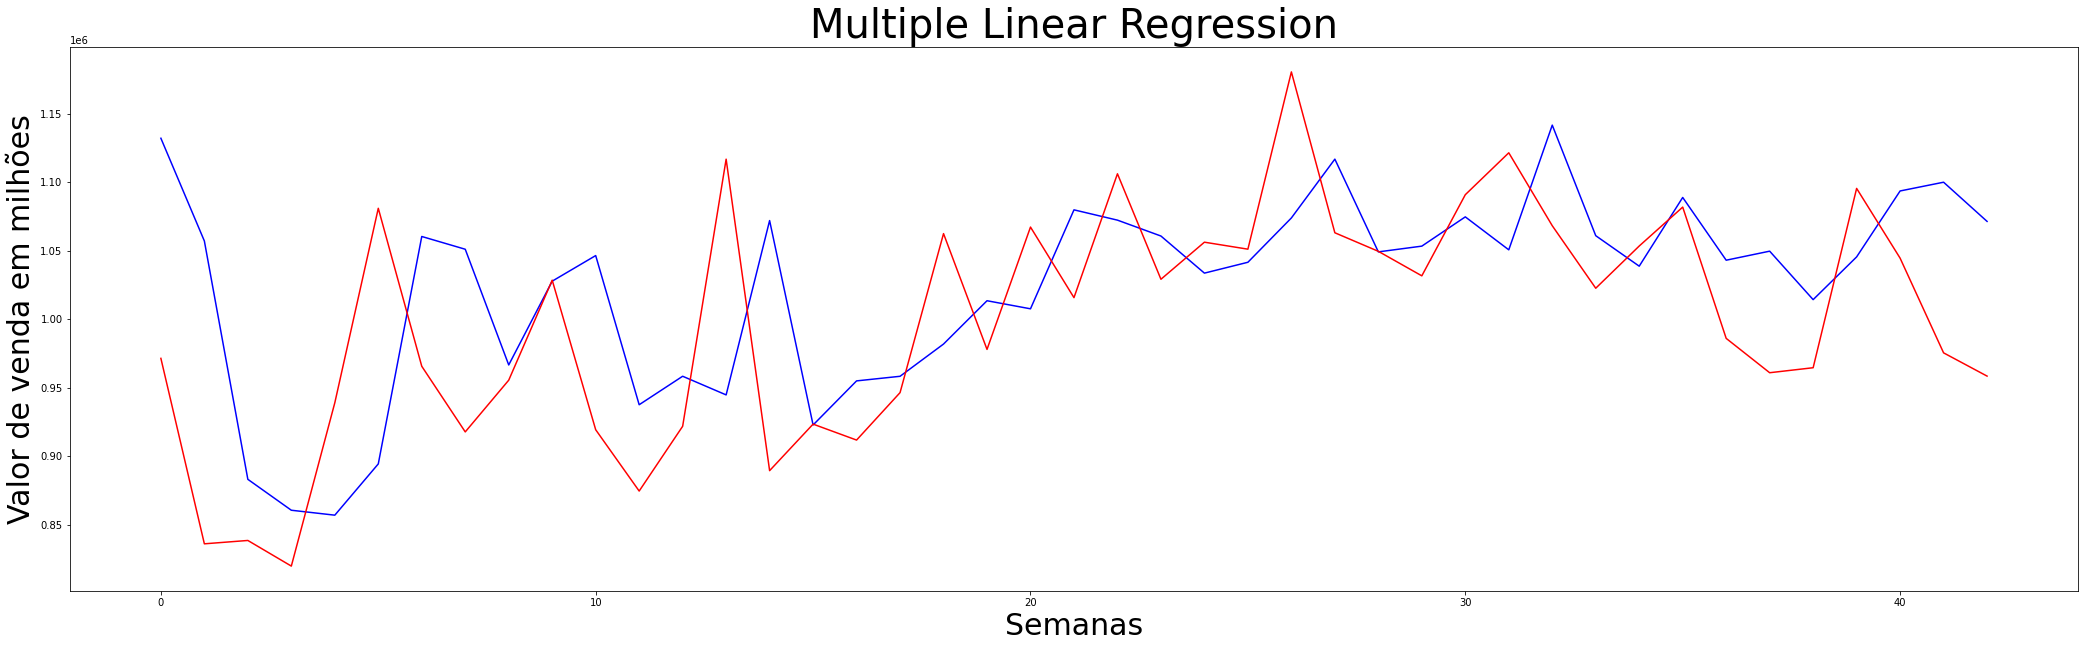

**************************************************
Resultados Loja 27:
0.18236405624773244 89956.94521852751 122126.49680226791


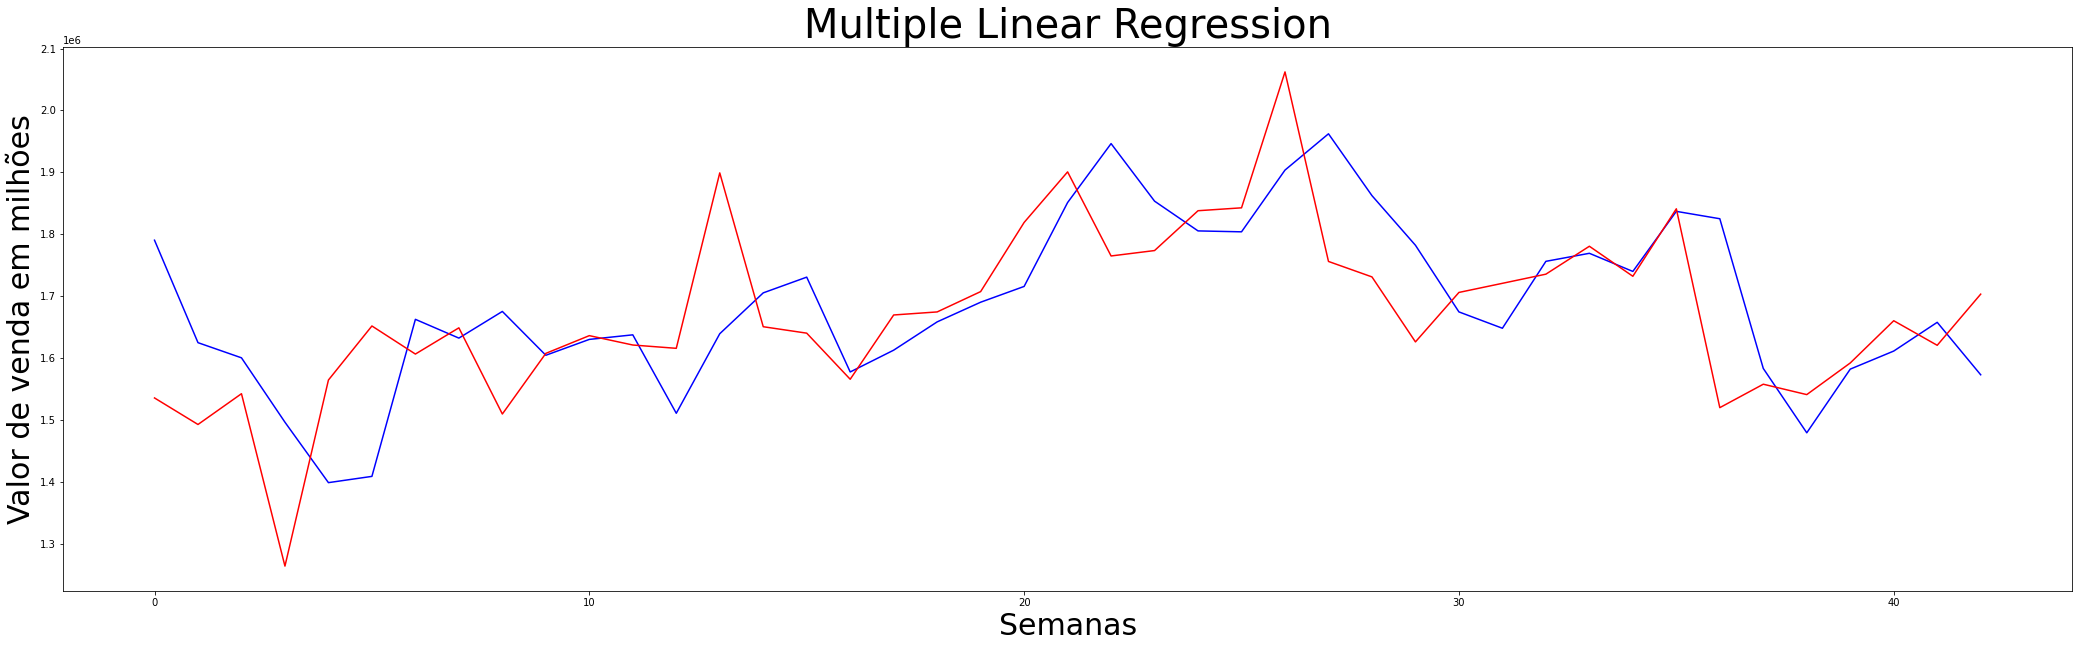

**************************************************
Resultados Loja 28:
0.08397914300067166 123806.44173367211 145719.77585279127


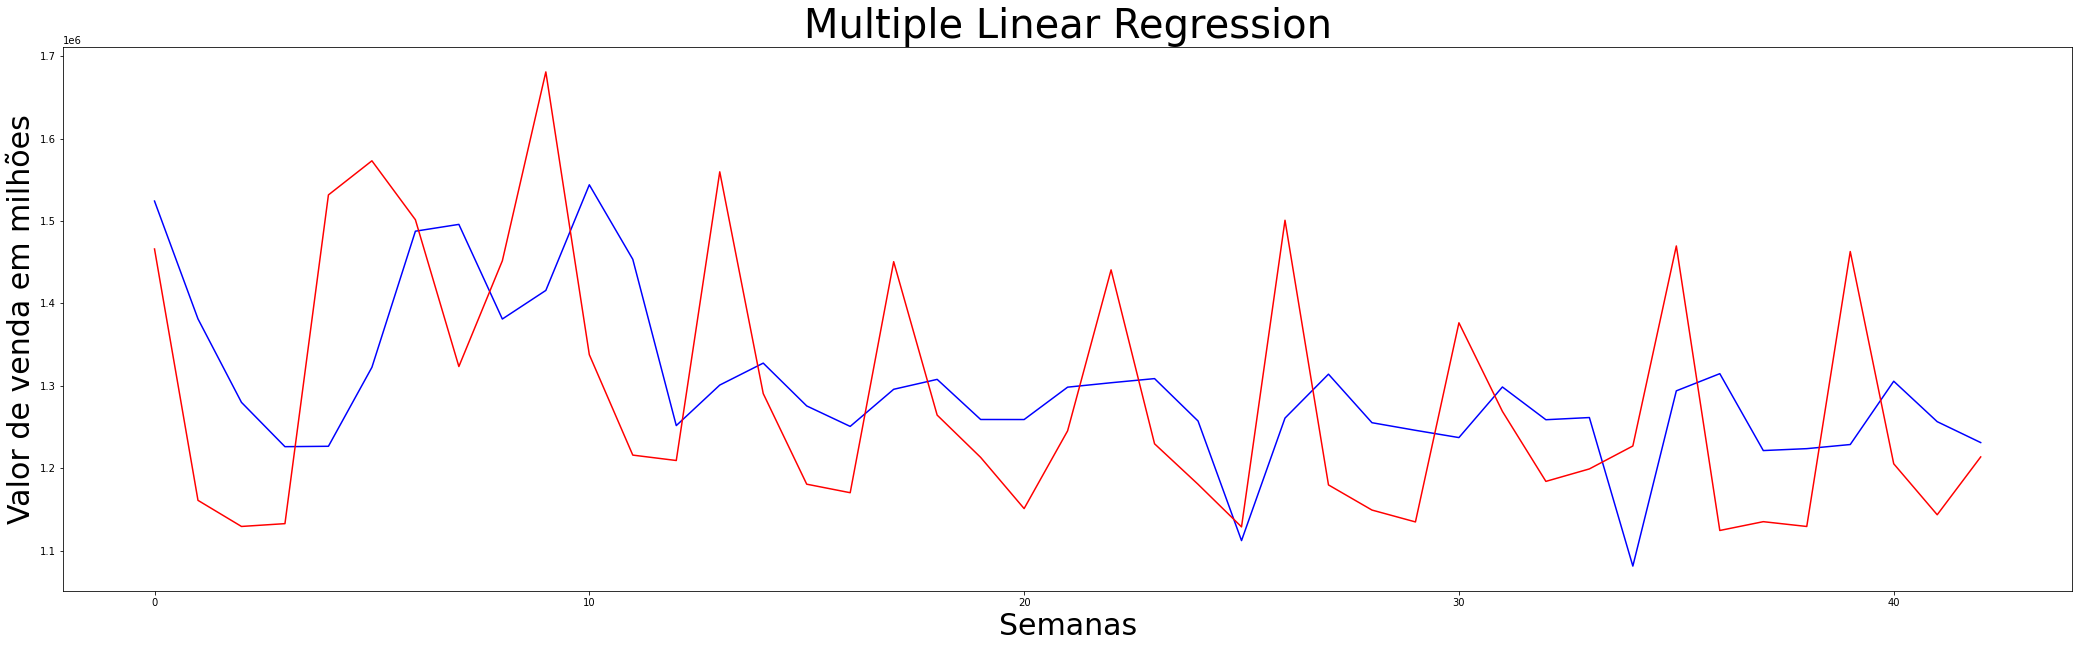

**************************************************
Resultados Loja 29:
-0.43599151605175646 37357.91551313917 55100.932884640686


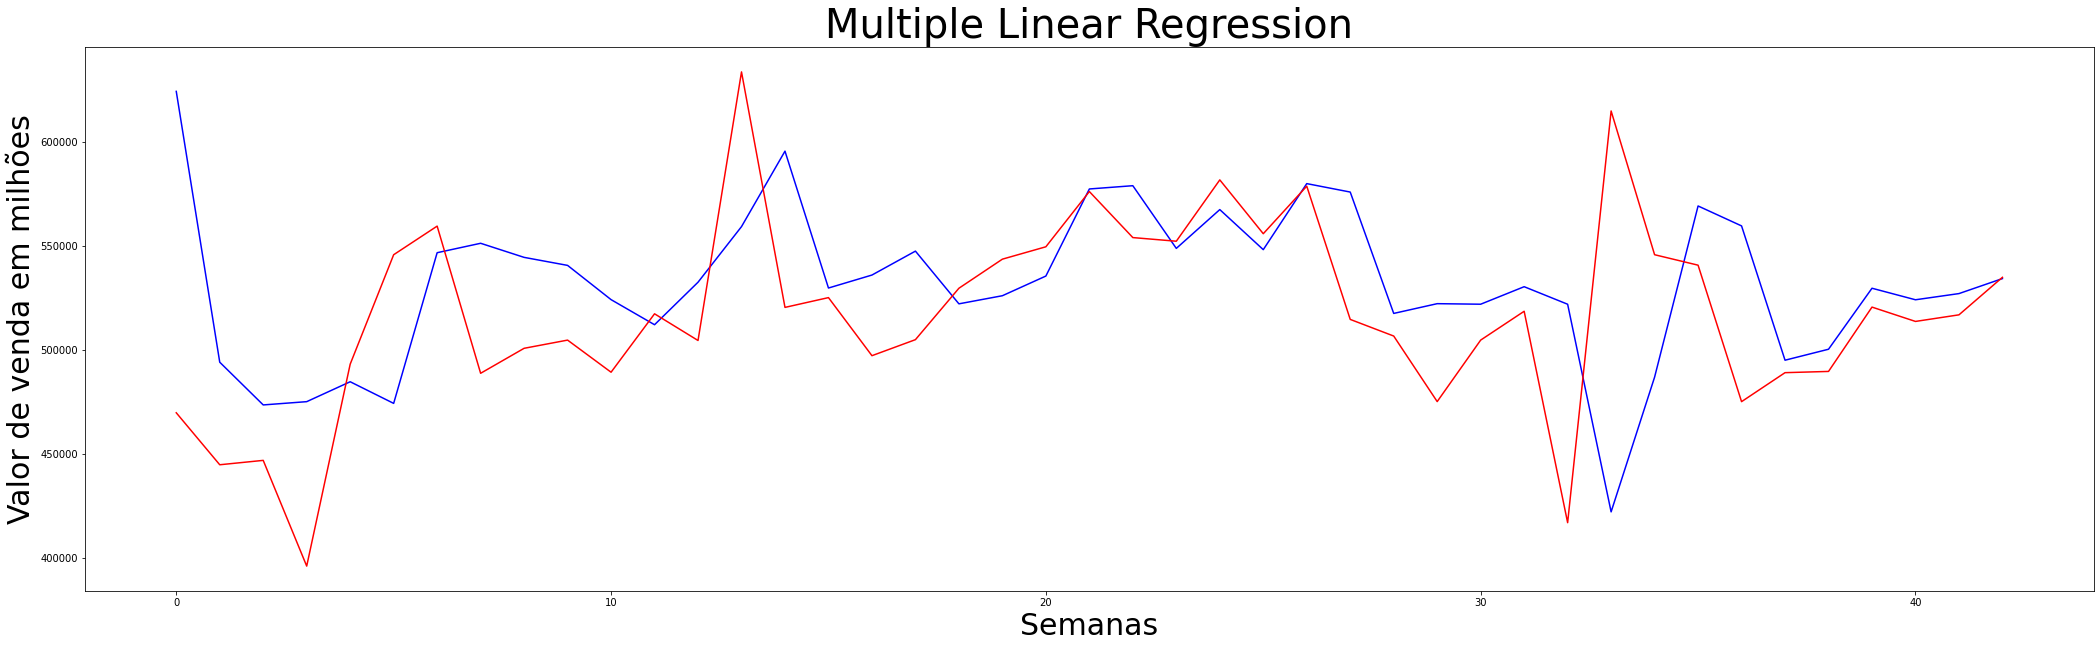

**************************************************
Resultados Loja 30:
-1.7933022739008386 15645.797015213213 19593.710160602703


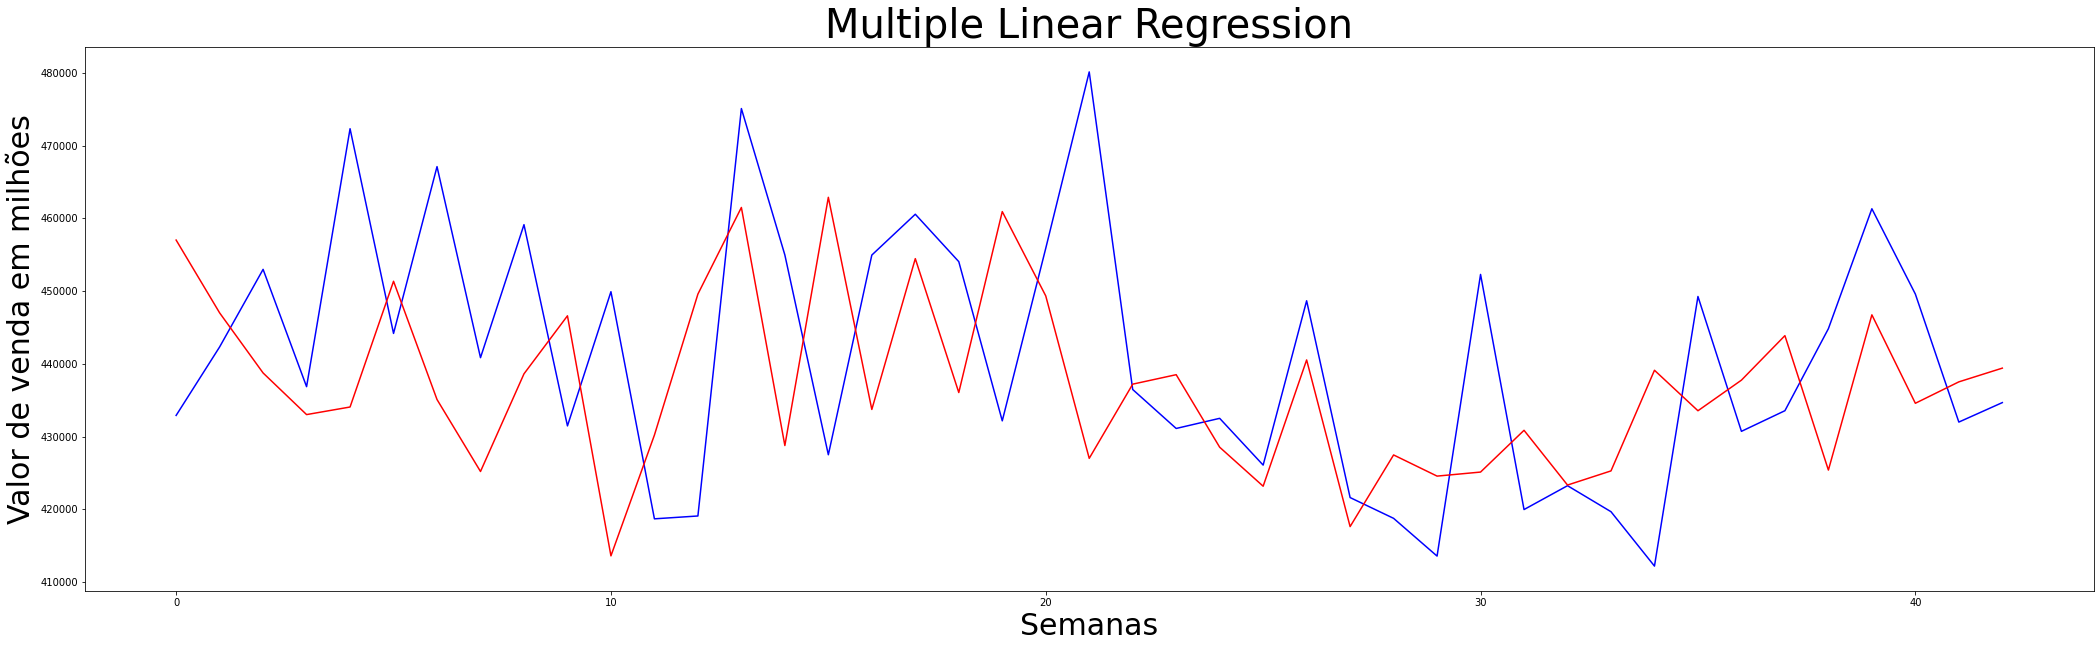

**************************************************
Resultados Loja 31:
-0.5603746308866115 54282.74130979933 73281.88063095523


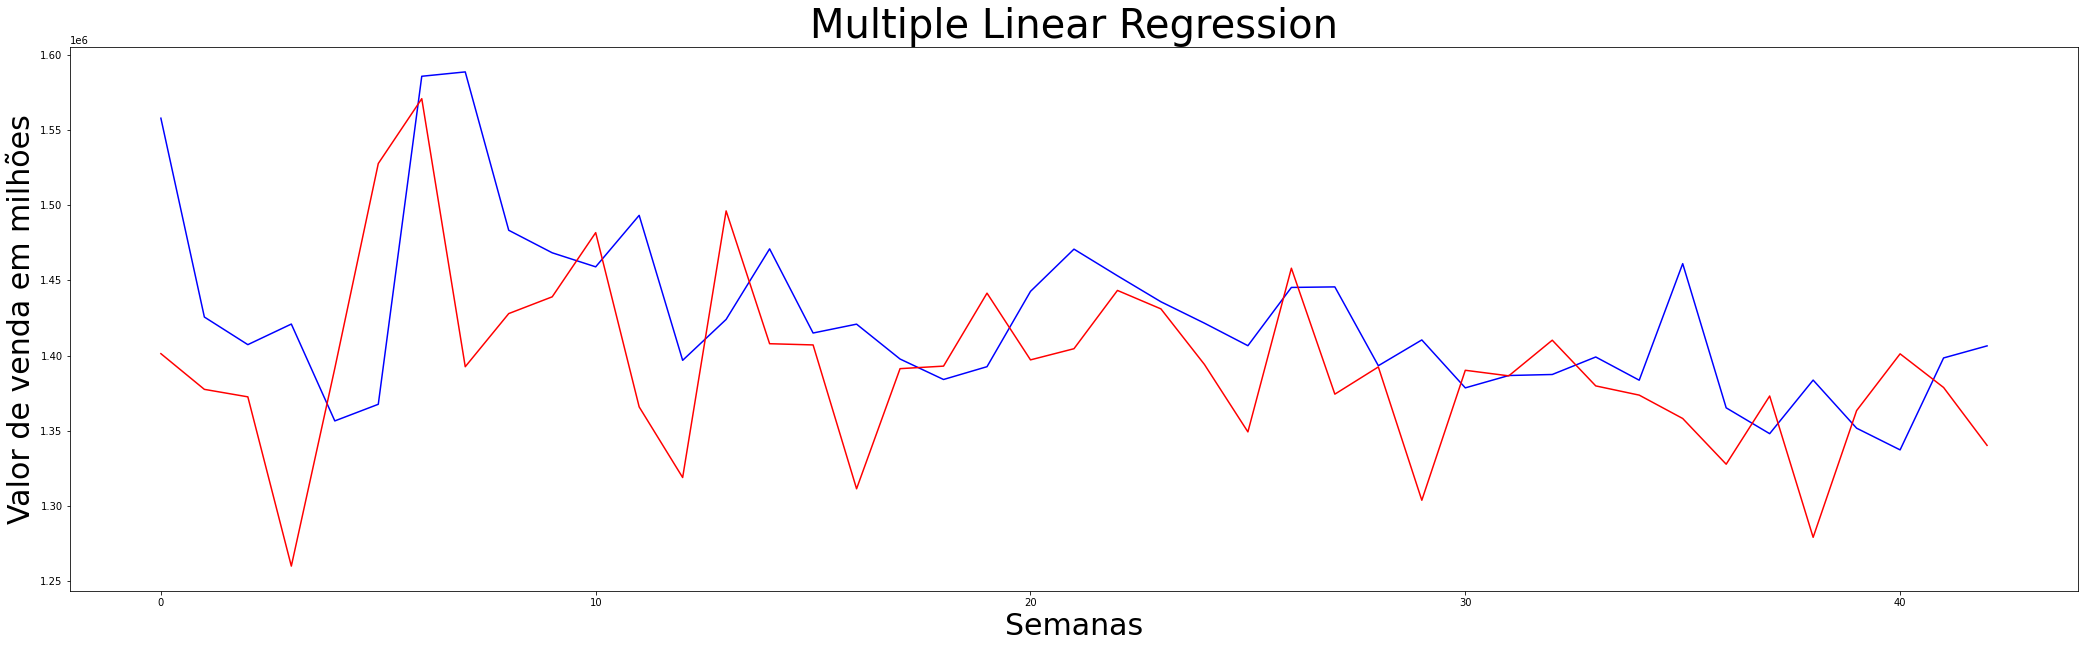

**************************************************
Resultados Loja 32:
-0.8533860637465525 56249.938663792534 72034.6781405015


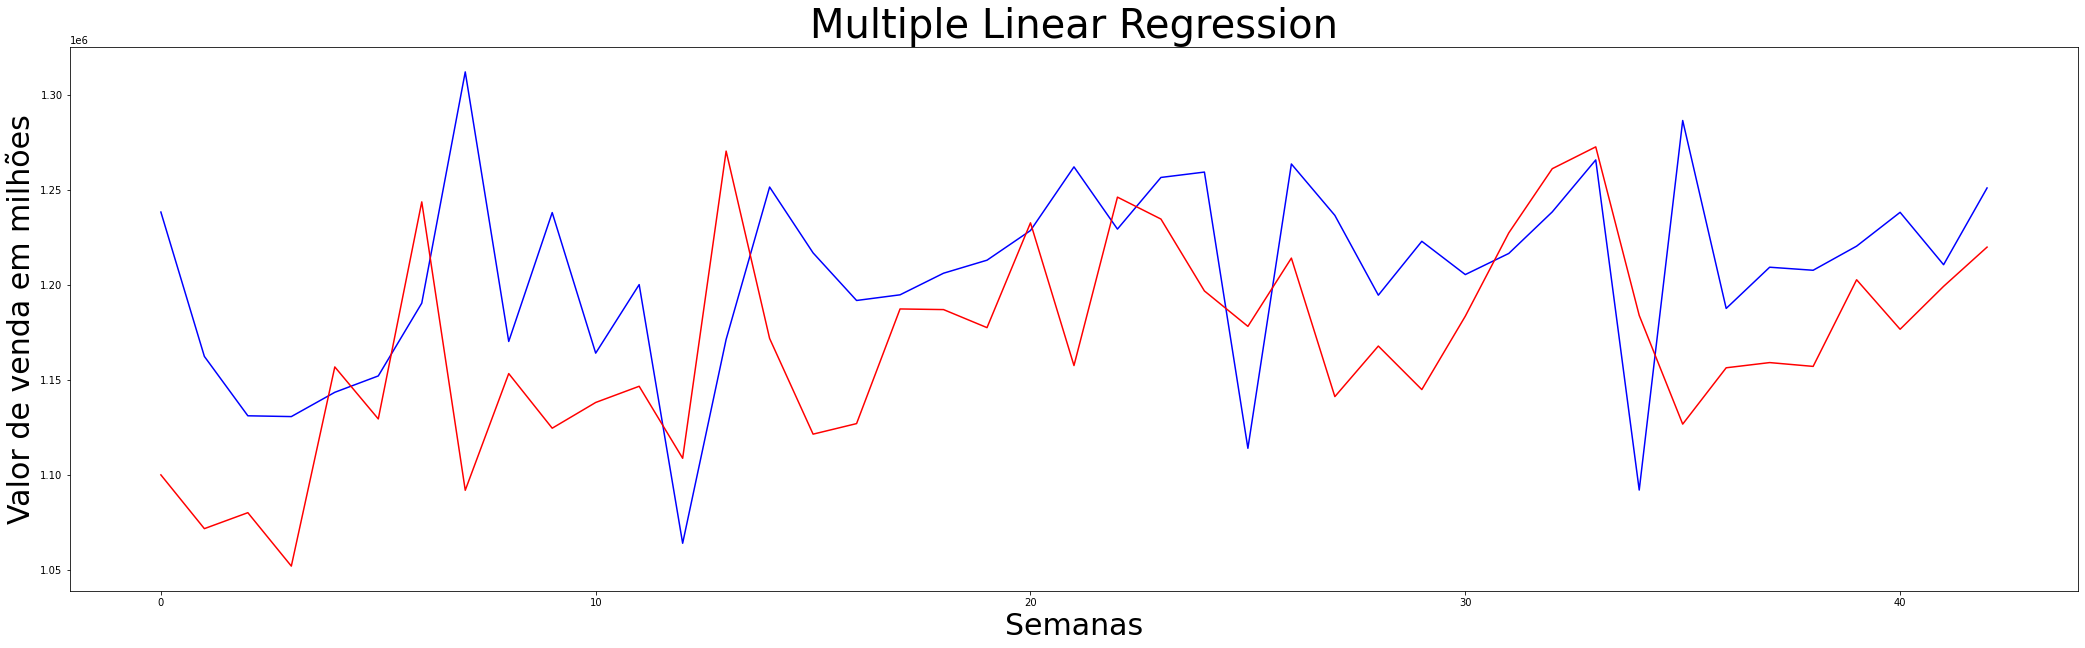

**************************************************
Resultados Loja 33:
0.11649940757331212 13985.568899610436 17216.712722380507


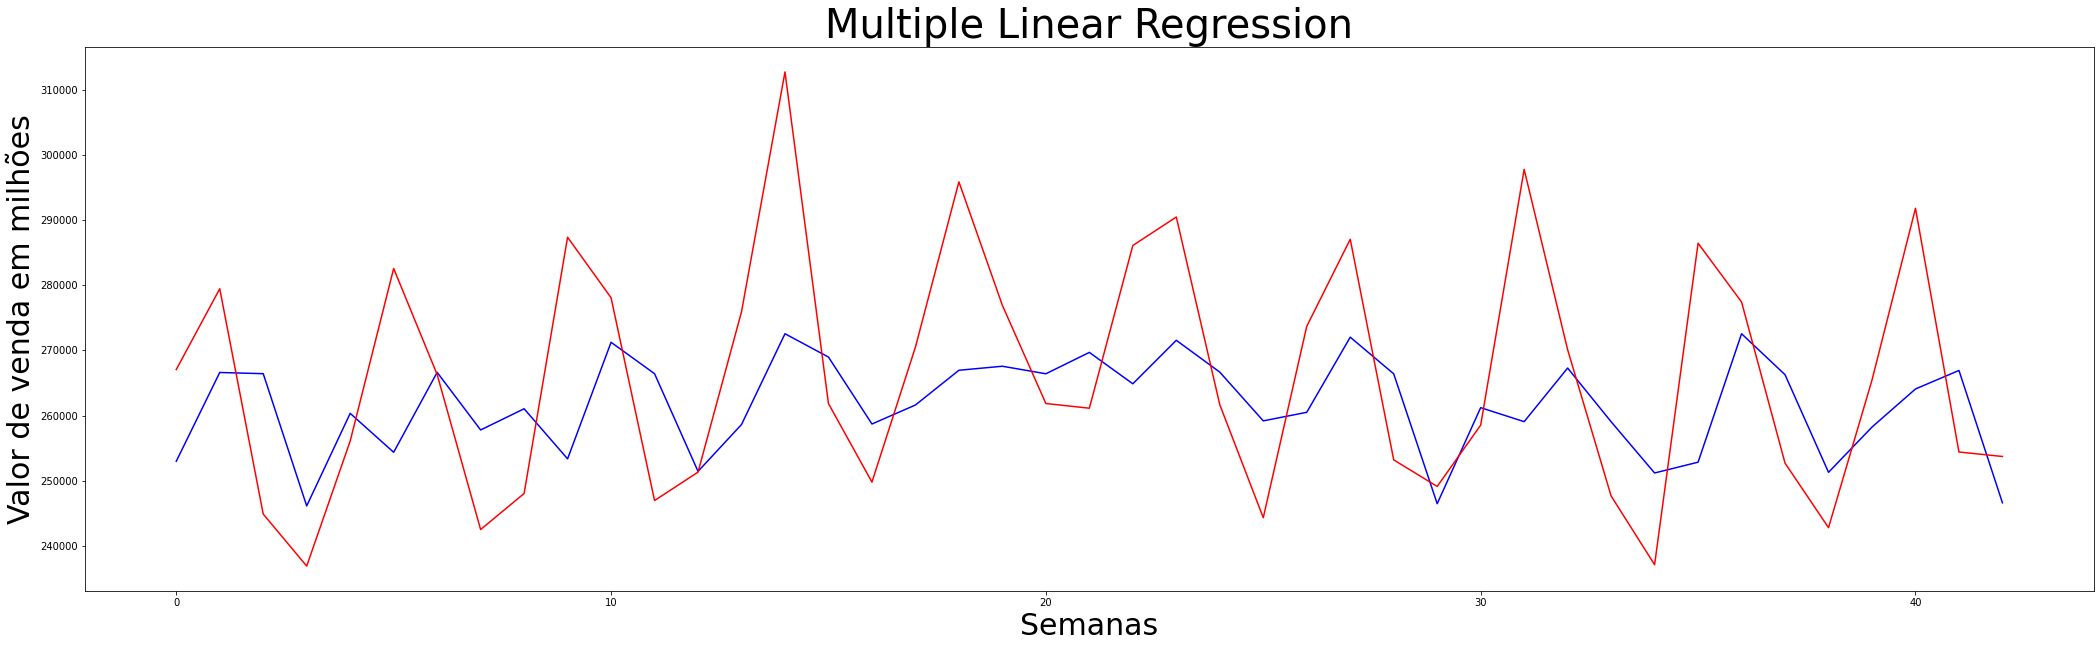

**************************************************
Resultados Loja 34:
-0.8537239767222207 44838.87971626232 61273.05689873138


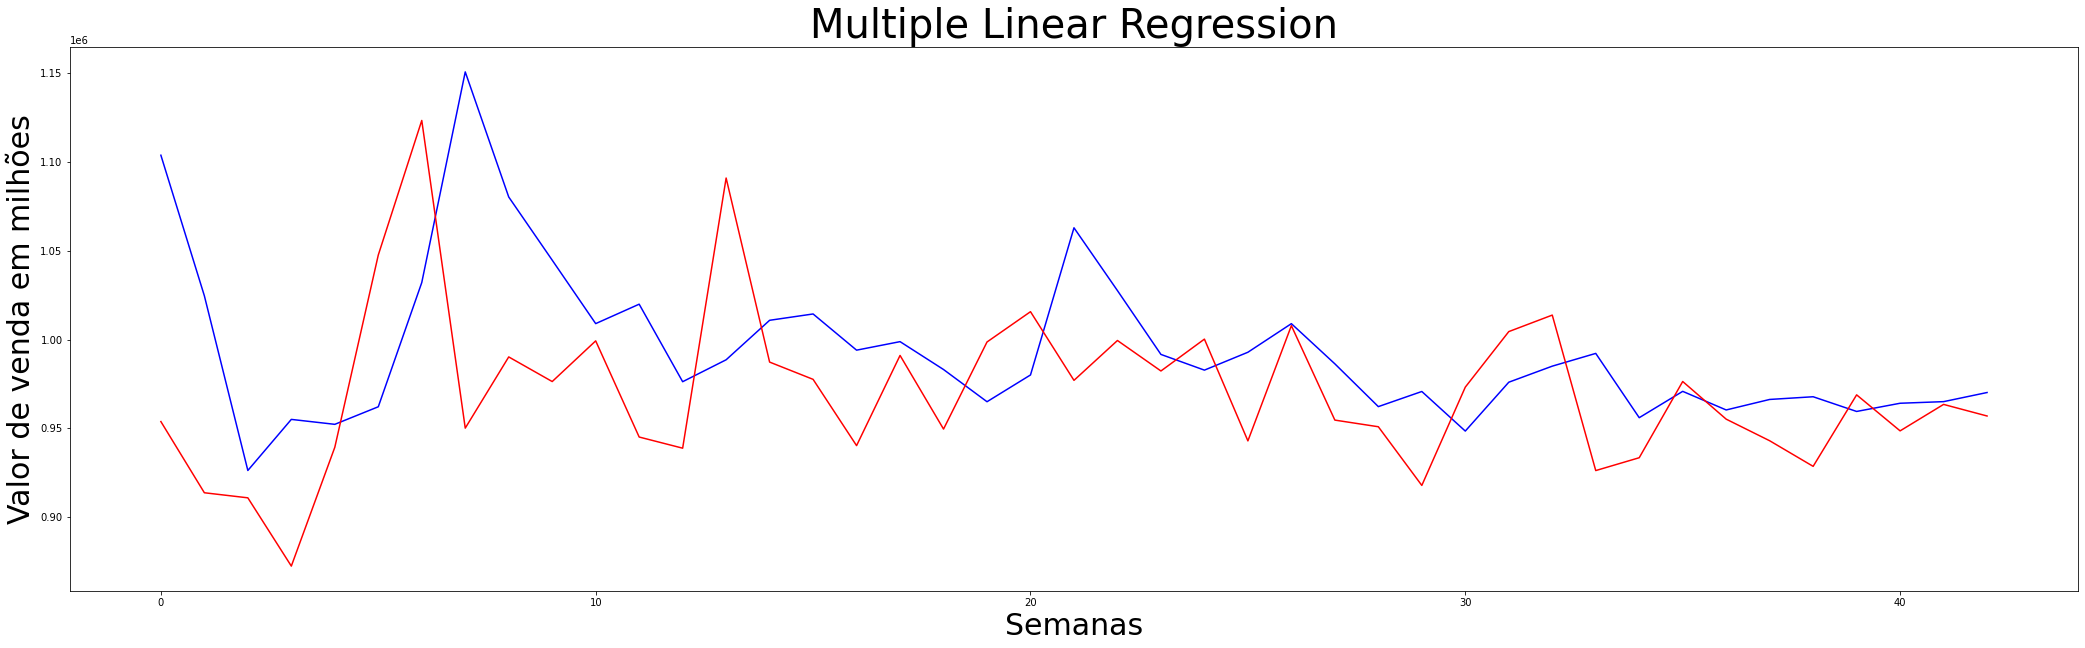

**************************************************
Resultados Loja 35:
0.19411154004478615 50107.160317108704 74405.00214895062


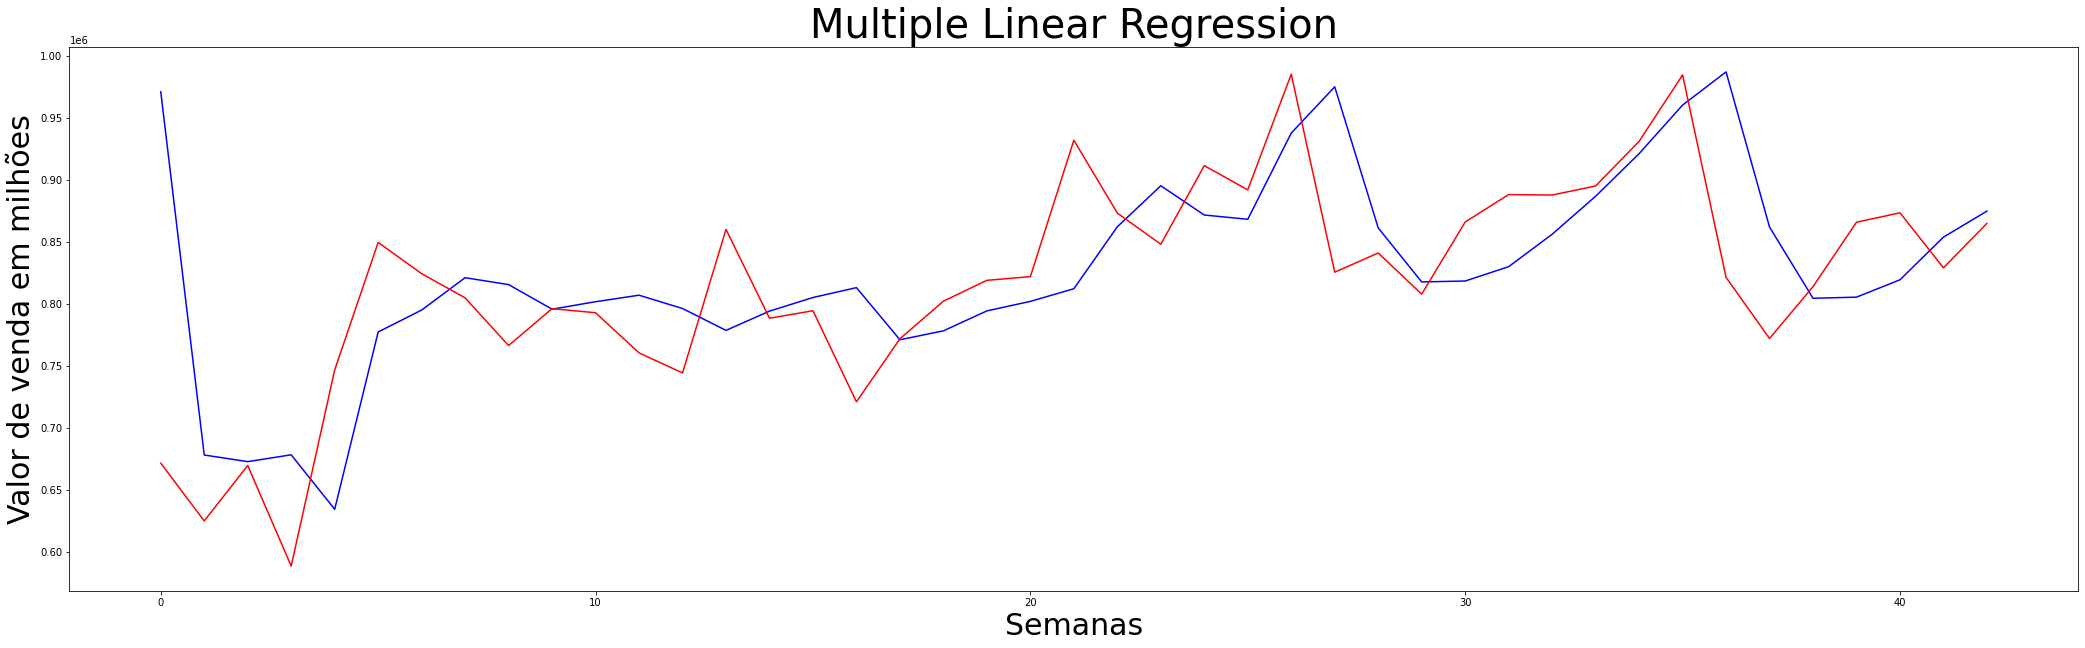

**************************************************
Resultados Loja 36:
-0.6975110286108241 19138.626250616995 24149.46291262124


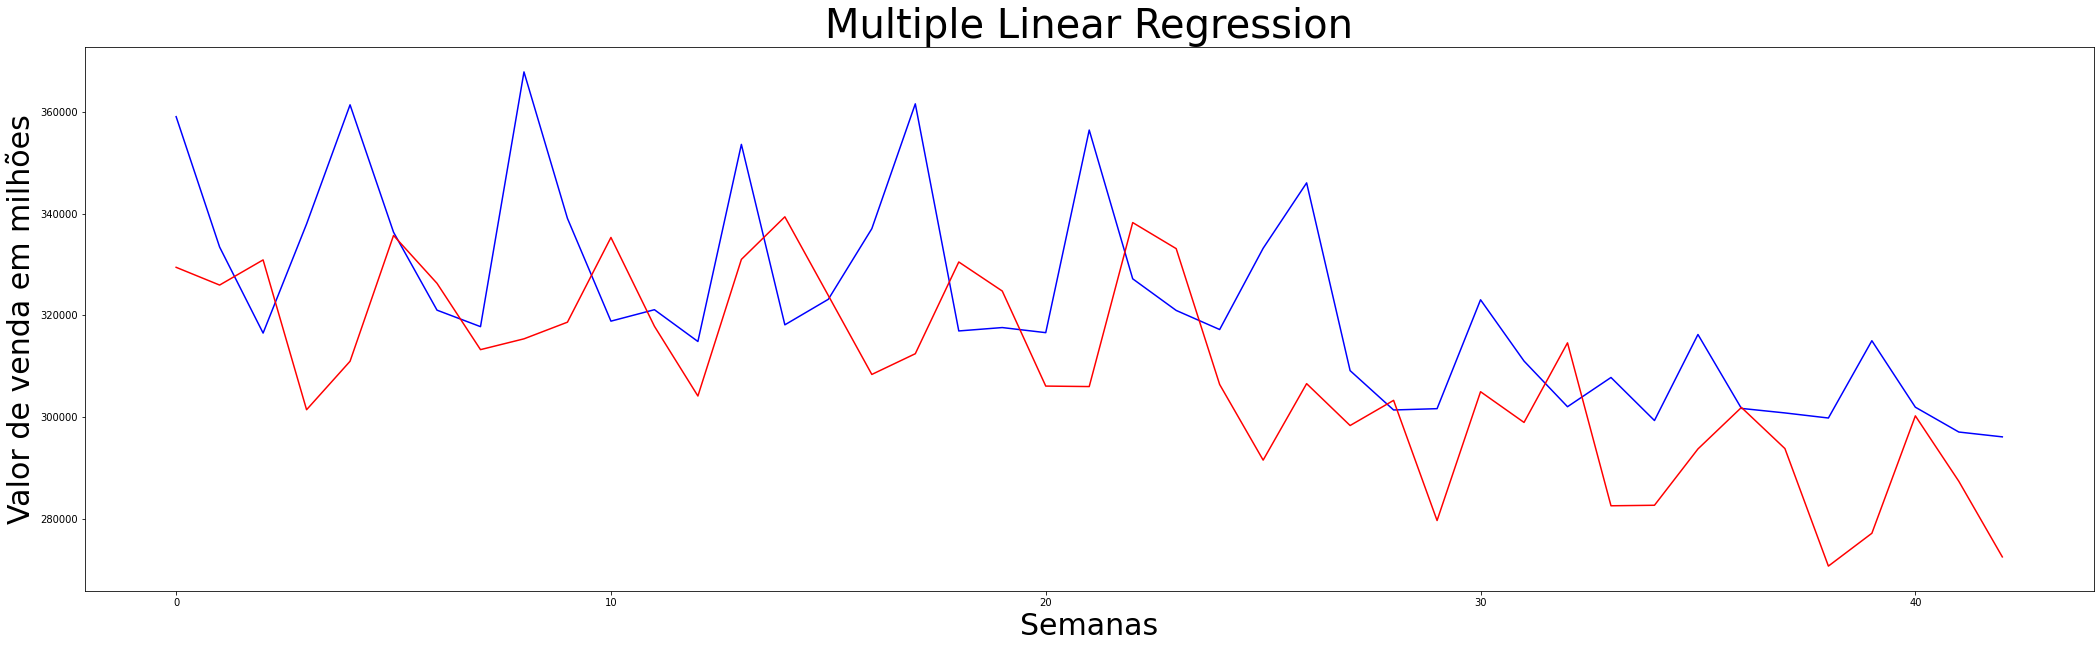

**************************************************
Resultados Loja 37:
-0.5368155381232214 16385.460946131163 21657.829353146877


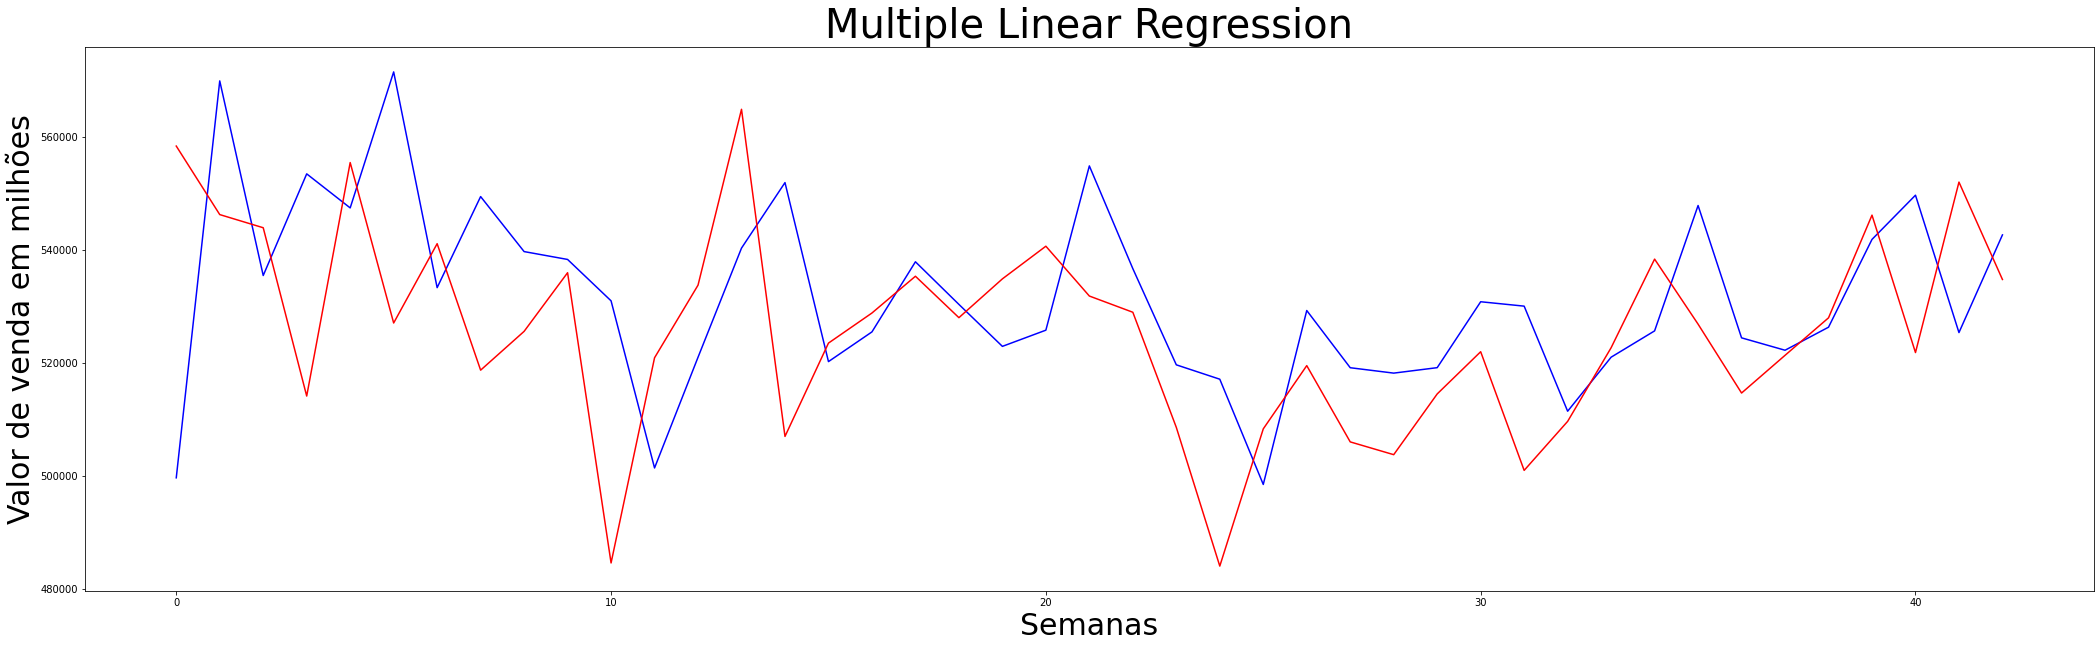

**************************************************
Resultados Loja 38:
-0.9792609558529737 31368.511705192206 38328.06398426755


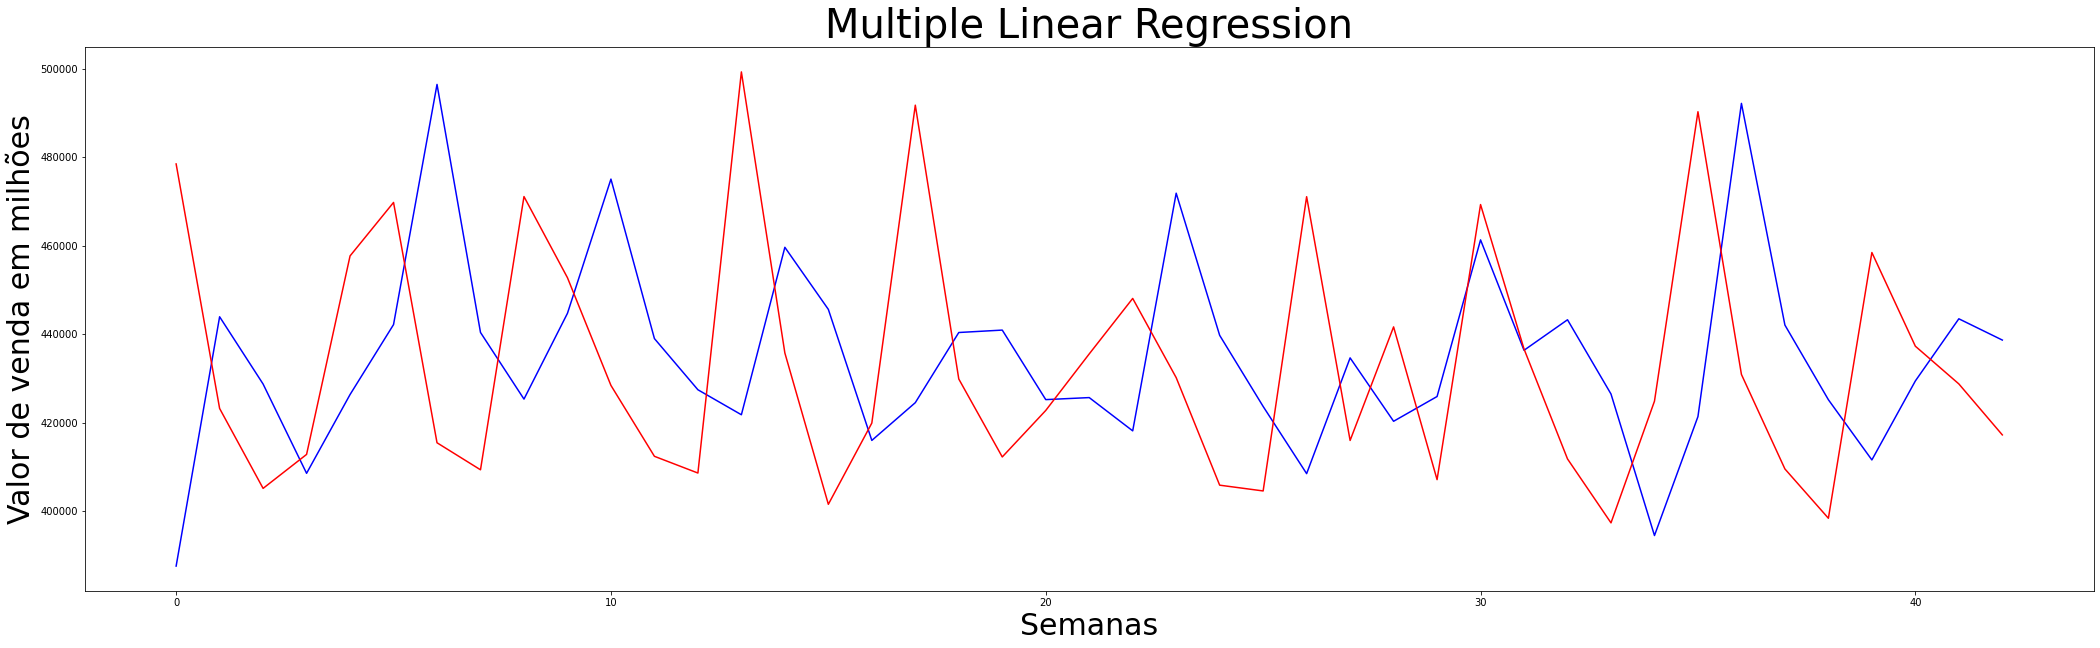

**************************************************
Resultados Loja 39:
0.1333903928218253 76610.21146802495 92310.32475764105


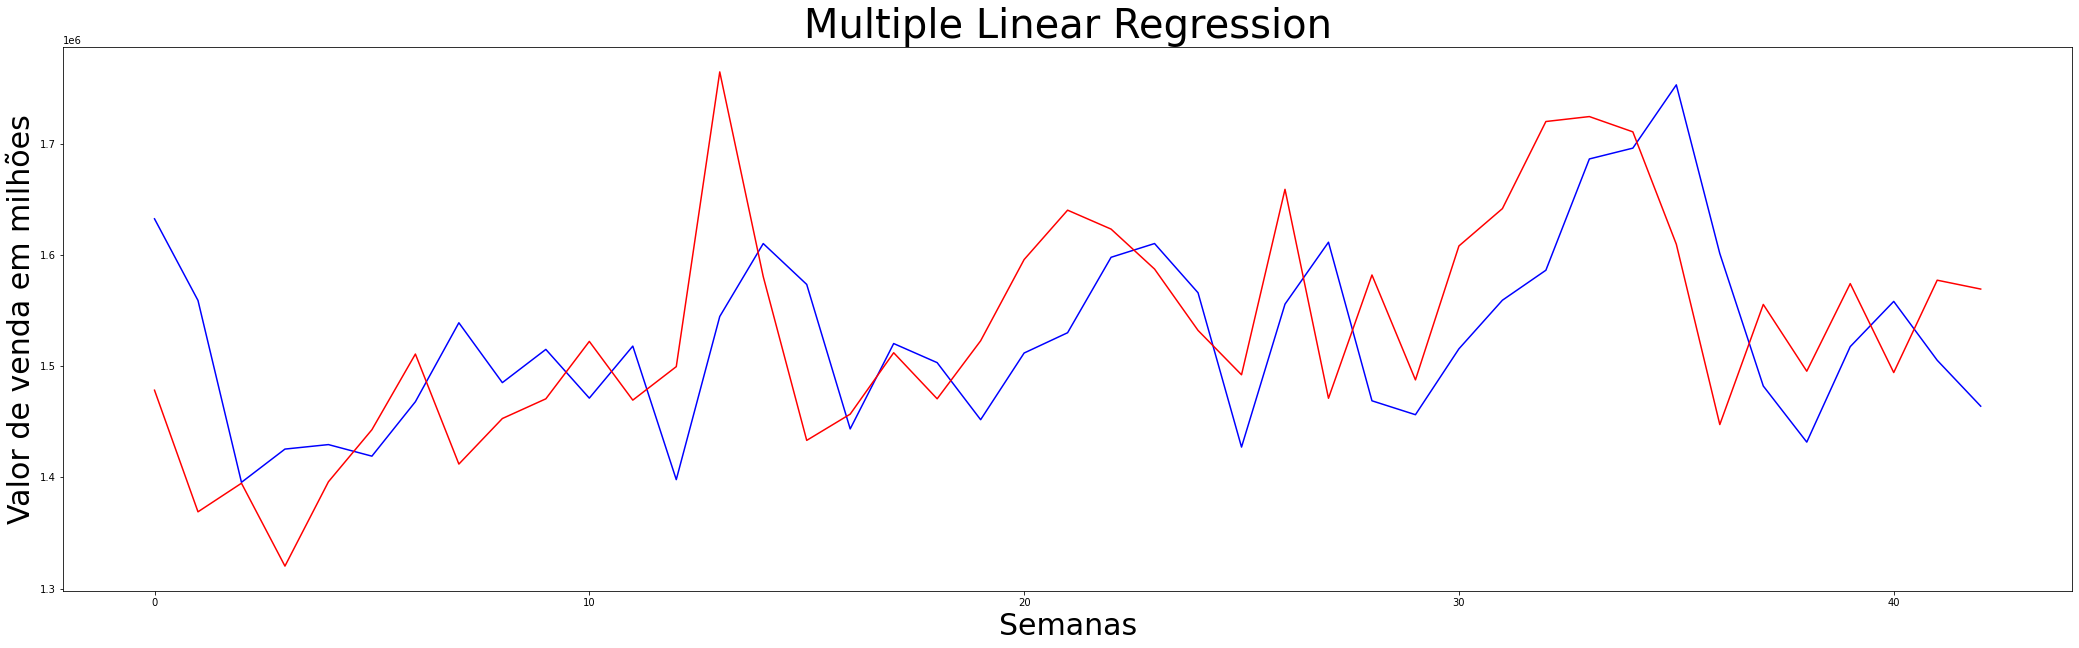

**************************************************
Resultados Loja 40:
-0.14858313360227227 68987.50294555625 91153.52084687163


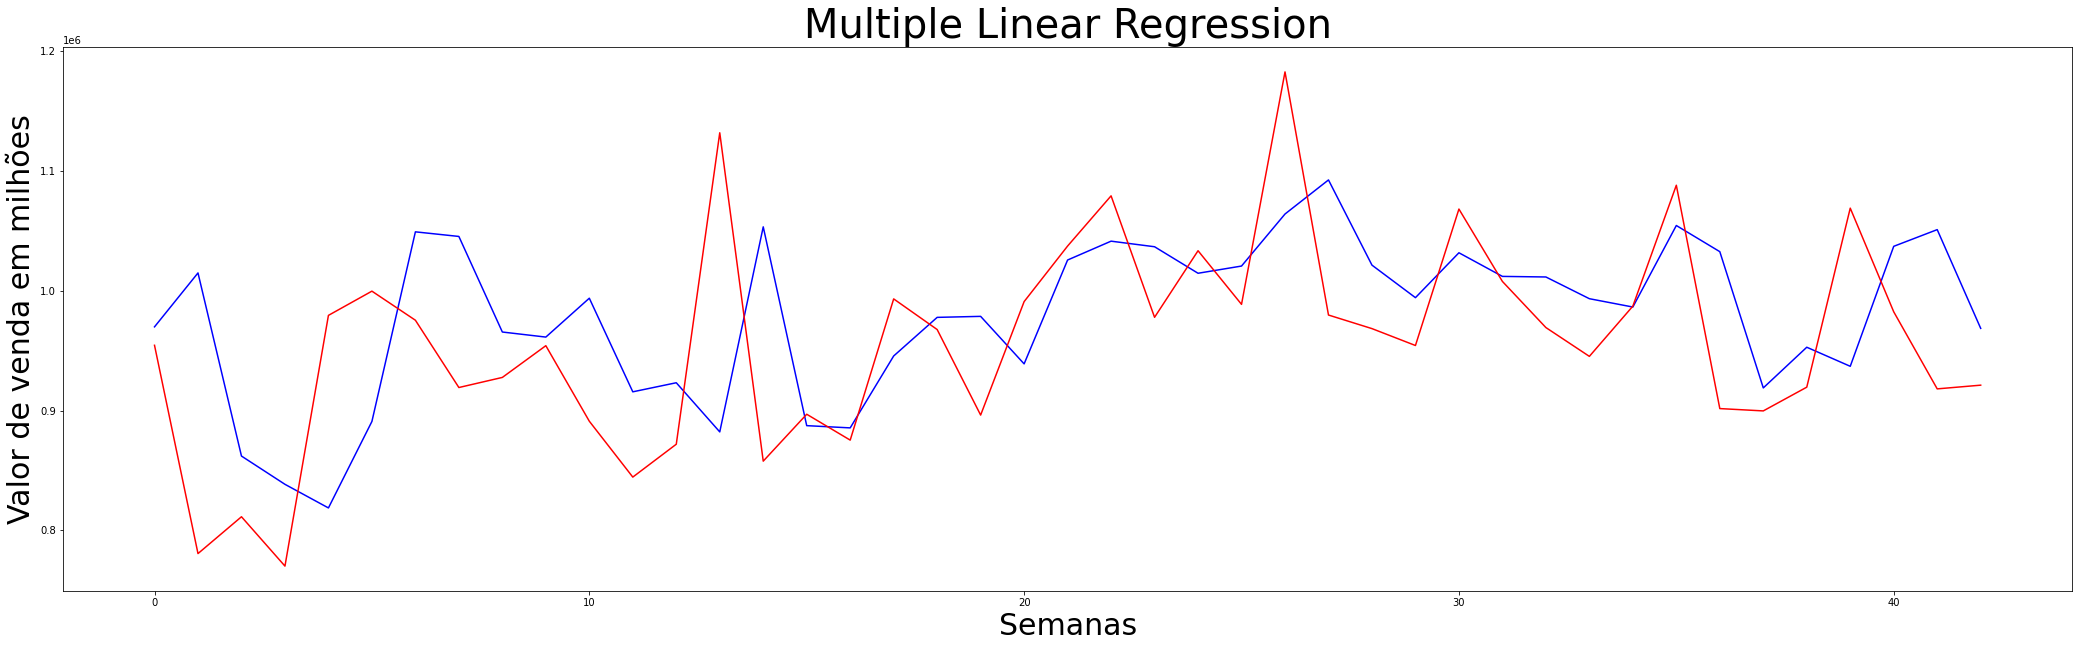

**************************************************
Resultados Loja 41:
0.1665286813231246 70634.30258936895 94742.24374145866


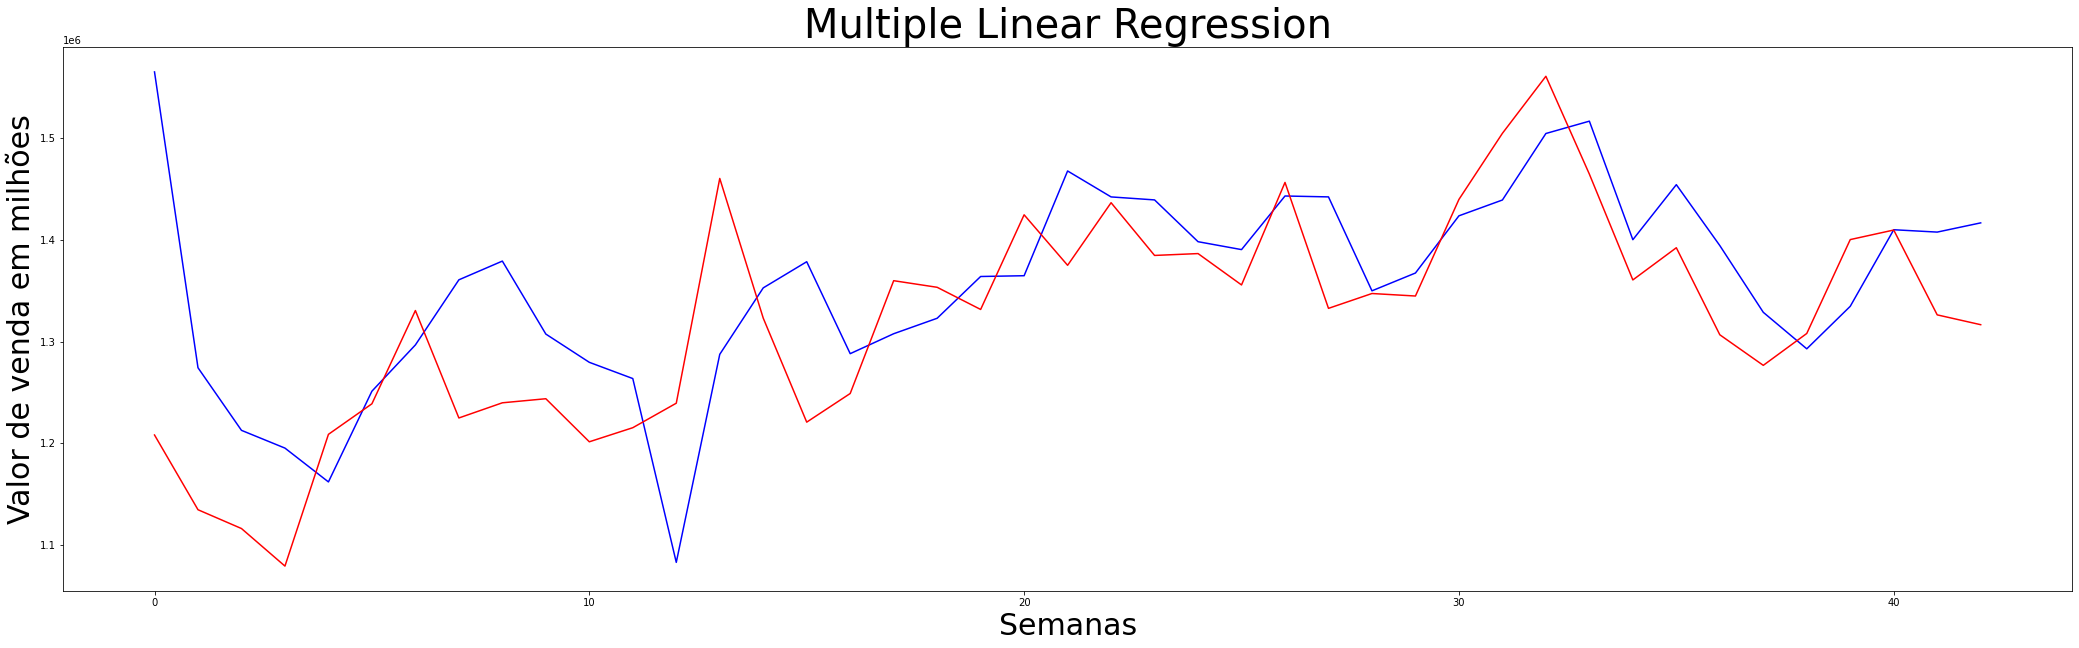

**************************************************
Resultados Loja 42:
0.023944546494547914 41261.90227481466 47744.247020966


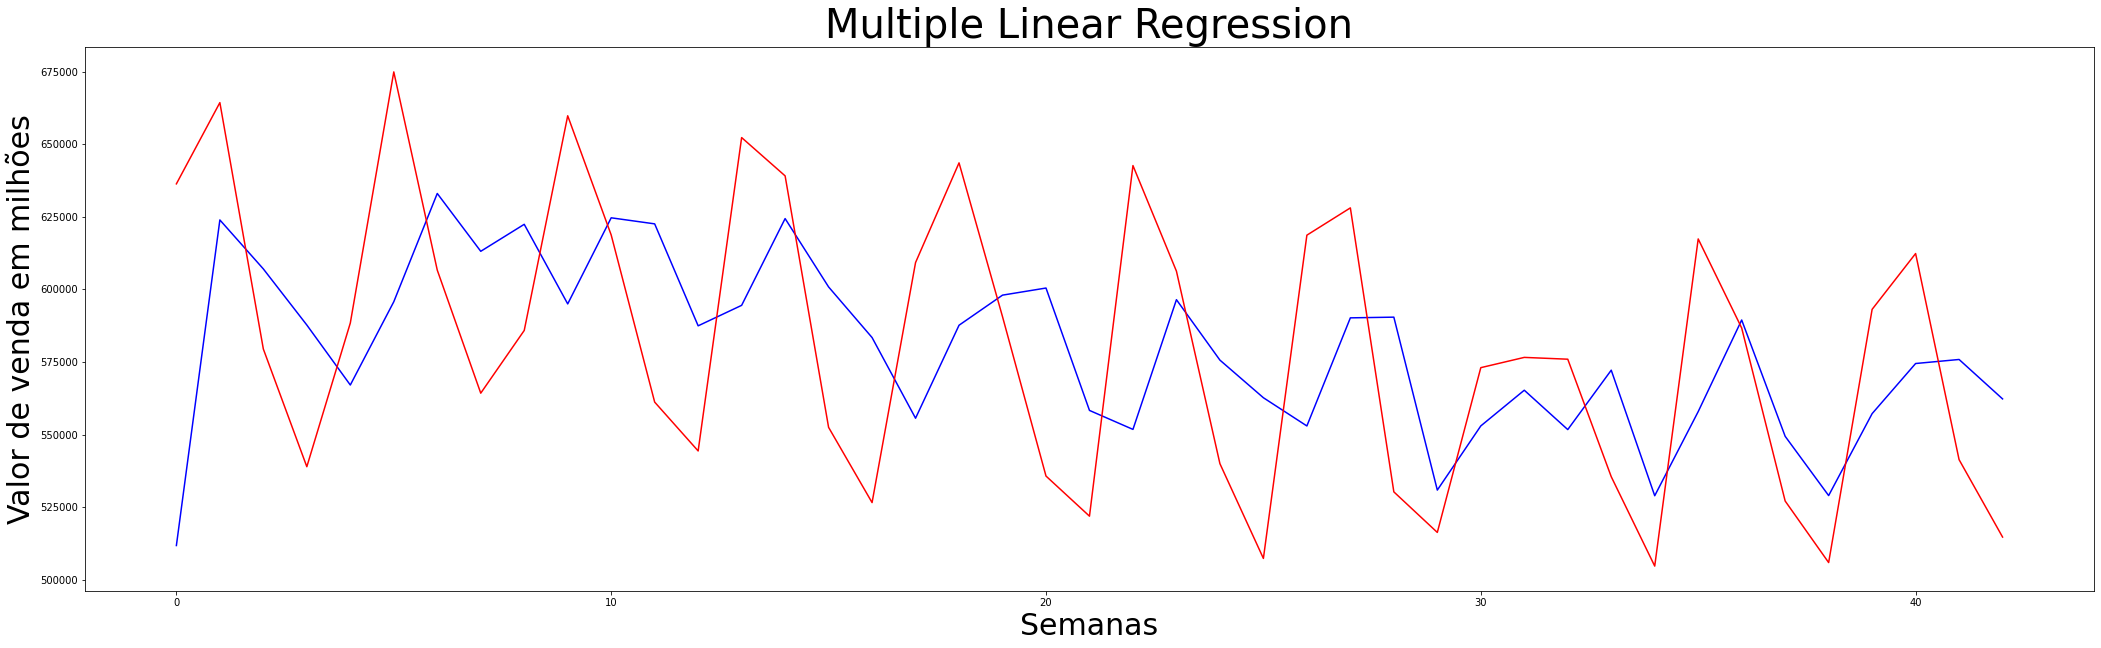

**************************************************
Resultados Loja 43:
-0.6183709632829257 27825.349233748304 35785.93349238169


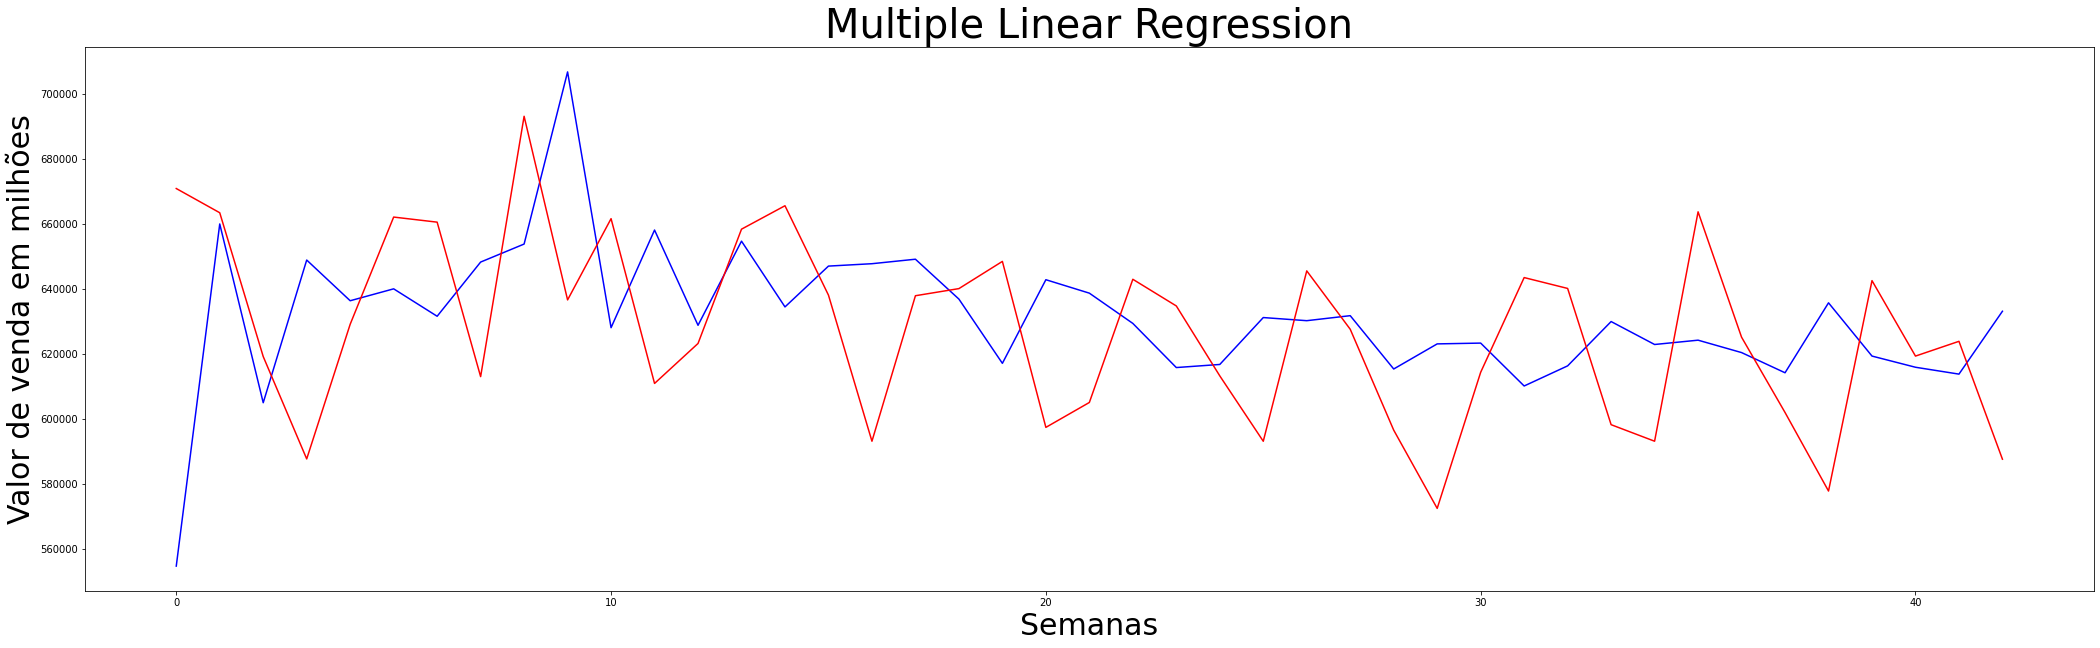

**************************************************
Resultados Loja 44:
-3.6171725610005314 20716.352268430837 29978.382054446276


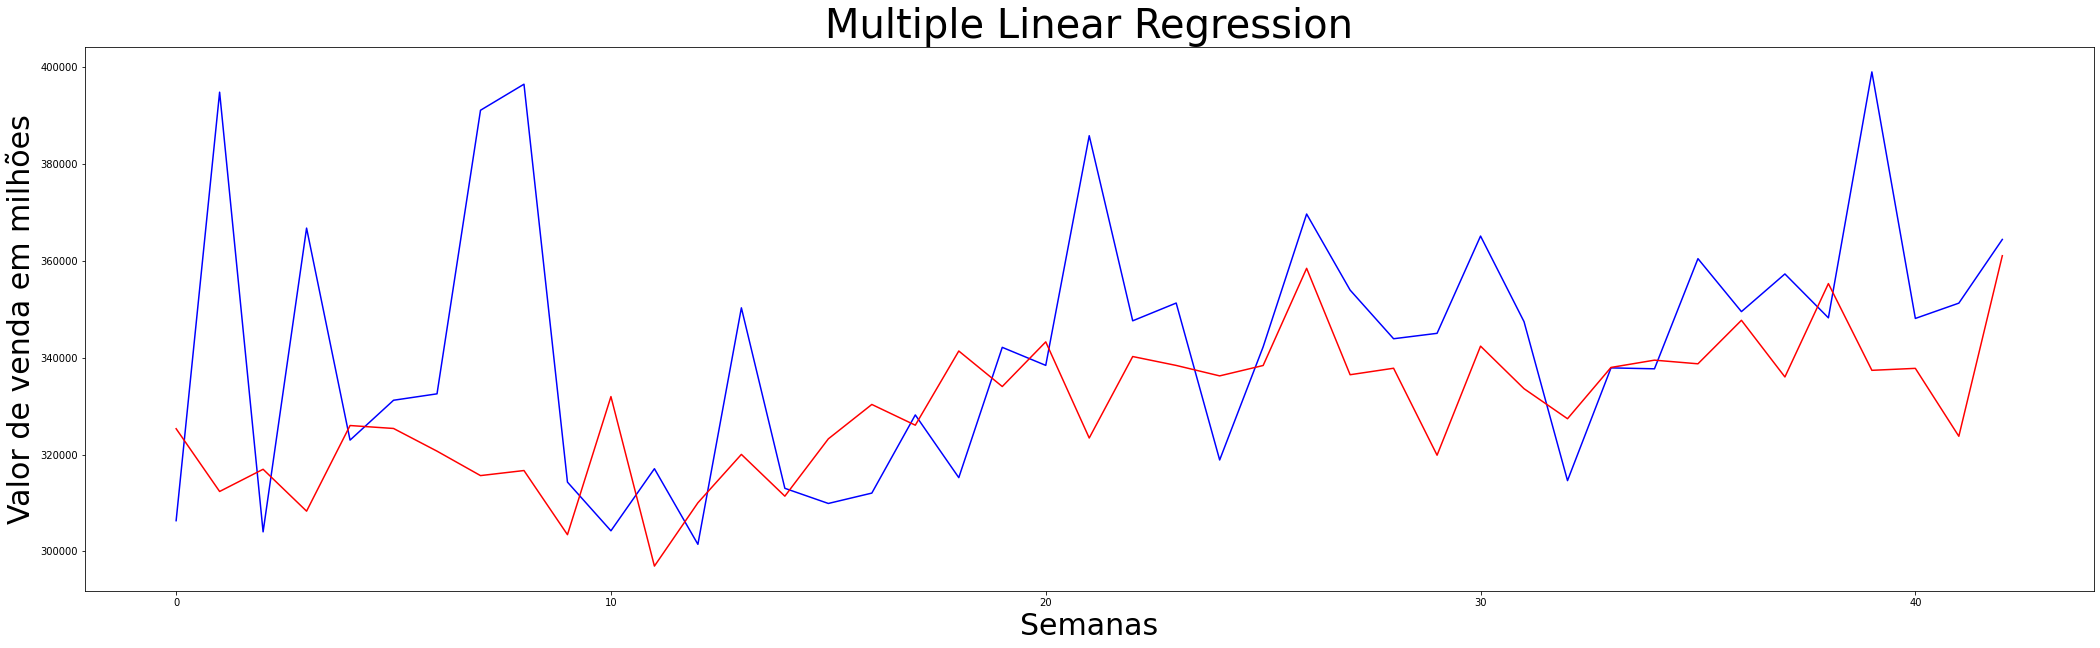

**************************************************
Resultados Loja 45:
-0.3660950623575332 41306.20296520714 60333.05849934913


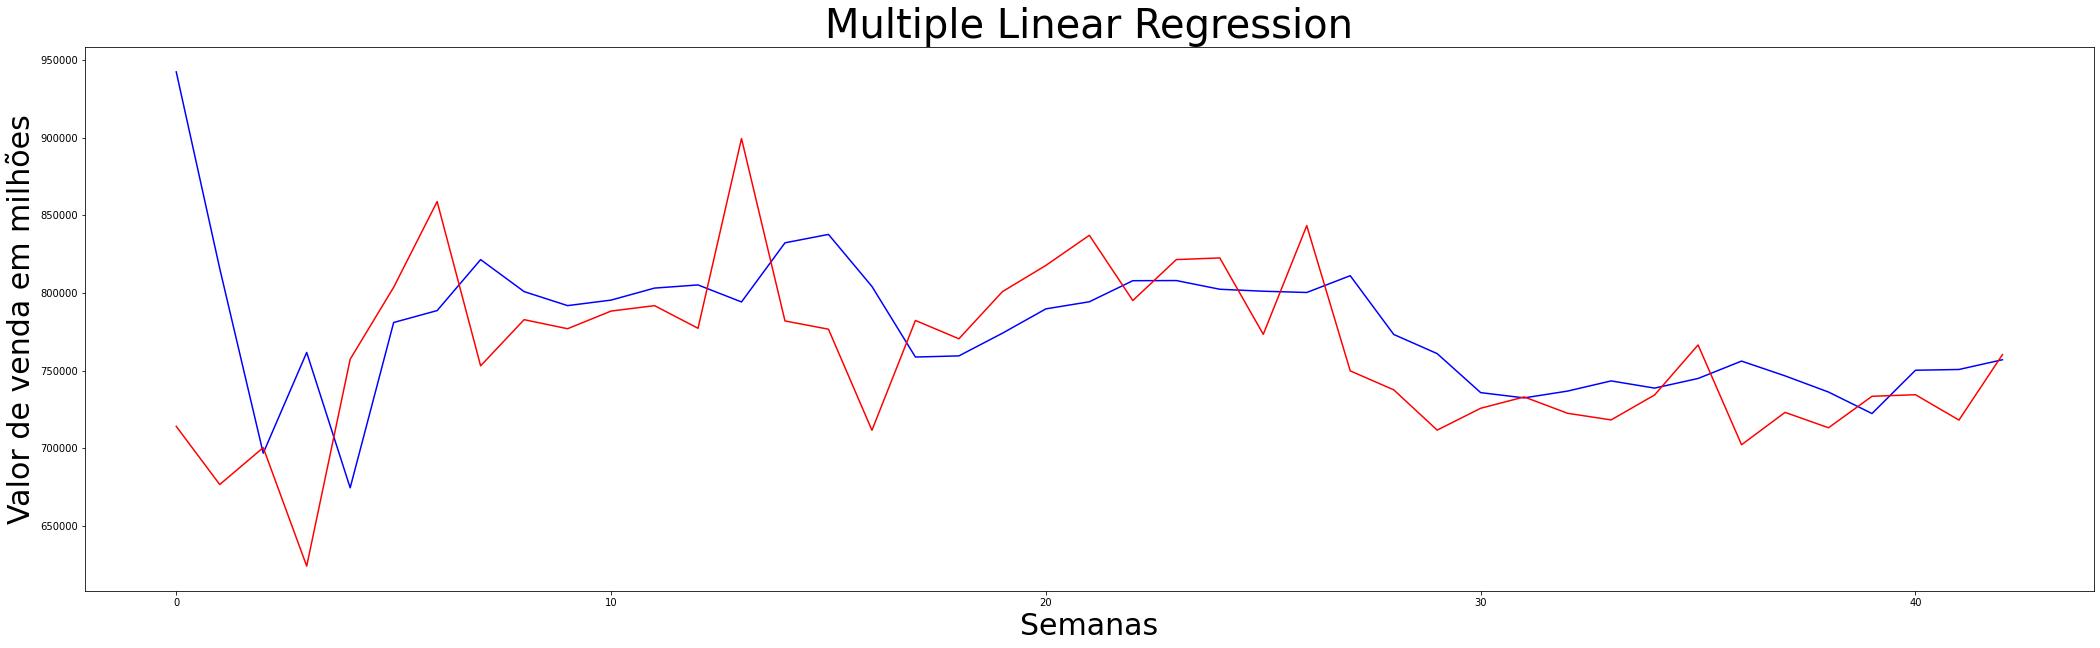

**************************************************


In [10]:
Xy_test = X_test
Xy_test["y"] = y_test

for i in range(1, 46):
  X_loja = Xy_test.where(Xy_test["Store_" + str(i)] == 1).dropna()
  y_loja = X_loja["y"]
  X_loja = X_loja.drop(["y"], axis=1)

  predictions_loja = rf.predict(X_loja)

  print("Resultados Loja {}:".format(i))
  print(r2_score(y_loja, predictions_loja), mean_absolute_error(y_loja, predictions_loja), np.sqrt(mean_squared_error(y_loja, predictions_loja)))
  
  plt.figure(figsize = (36, 10)) 
  plt.plot(range(len(predictions_loja)), predictions_loja, 'b')
  plt.plot(range(len(predictions_loja)), y_loja, 'r')
  plt.title("Multiple Linear Regression", fontsize=40)
  plt.xlabel("Semanas", fontsize=30)
  plt.ylabel("Valor de venda em milhões", fontsize=30)

  plt.show()
  
  print(50*"*")
